# Analyse de données  <a class="tocSkip">

L'objectif de ce notebook est de mieux comprendre les données et analyses de l'article *Mutation dynamics and fitness effects followed in single cells*, par Lydia Robert, Jean Ollion, Jerome Robert, Xiaohu Song, Ivan Matic et Marina Elez (Science, 2018).

# Data exploration

In [1]:
library("gridExtra")
library("ggplot2")
library("zoo")
library("MASS")


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





## Mutation Accumulation experiment : data_microMA
### Files description

On se base sur les données fournies en annexe de l'article, ainsi que leur description.

The folder contains 4 files giving the evolution of growth rate during one representative $\mu$MA experiment for 4 different strains, *mutH*, *mutT*, WT, MF1 (dataset_microMA_...) . Each column contains the values of one variable (time, generation or growth rate) for each time step for the mother cell of a single microchannel. The first two lines (i.e. first two values for each column) give respectively the index of the field of view and the index of the microchannel (~15channels for each field of view).

In [2]:
microMA_WT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_WT.csv")
microMA_MutH <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutH.csv")
microMA_MF1 <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MF1.csv")
microMA_MutT <- read.csv2("doi_10/All_data/data_microMA/dataset_microMA_MutT.csv")

# Split the channel information (first 2 lines) from the growth rates
microMA_WT_channels <- microMA_WT[c(1,2),]
microMA_WT <- microMA_WT[-c(1,2),]
microMA_MutH_channels <- microMA_MutH[c(1,2),]
microMA_MutH <- microMA_MutH[-c(1,2),]
microMA_MF1_channels <- microMA_MF1[c(1,2),]
microMA_MF1 <- microMA_MF1[-c(1,2),]
microMA_MutT_channels <- microMA_MutT[c(1,2),]
microMA_MutT <- microMA_MutT[-c(1,2),]

In [3]:
tail(microMA_MutH[,1:9], 10)

time generation growth.rate time.1 generation.1 growth.rate.1 time.2
993  3960 182        0.02770213  3960   121          0.01443289    3960  
994  3964 182        0.02770213  3964   121          0.01443289    3964  
995  3968 182        0.02770213  3968   122          0.01675265    3968  
996  3972 182        0.02770213  3972   122          0.01675265    3972  
997  3976 182        0.02770213  3976   122          0.01675265    3976  
998  3980 183        0.02867049  3980   122          0.01675265    3980  
999  3984 183        0.02867049  3984   122          0.01675265    3984  
1000 3988 183        0.02867049  3988   122          0.01675265    3988  
1001 3992 183        0.02867049  3992   122          0.01675265    3992  
1002 3996 183        0.02867049  3996   122          0.01675265    3996  
     generation.2 growth.rate.2
993  163          0.001285689  
994  163          0.001285689  
995  164          0.026031184  
996  164          0.026031184  
997  164          0.026031184  
998  164          0.026031184  
999  165          0.025671465  
1000 165          0.025671465  
1001 165          0.025671465  
1002 165          0.025671465

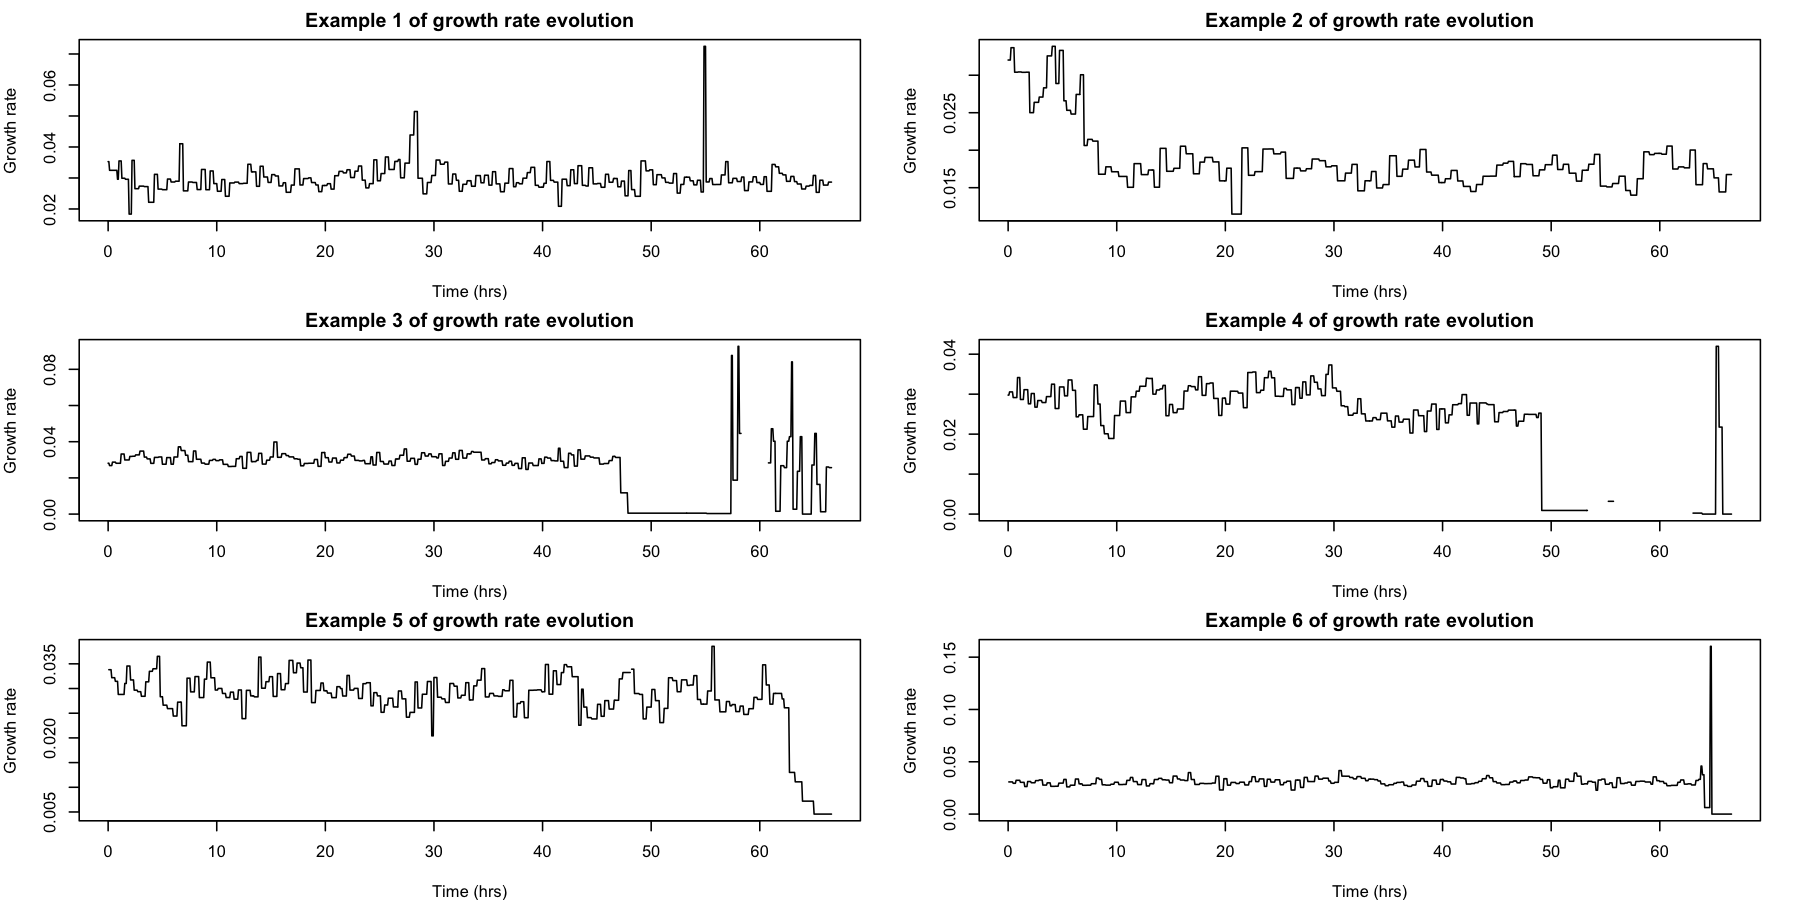

In [4]:
#png("Img/Growth_rates_examples.png", width = 800, height = 400)

microMA_MutH_growthRates <- microMA_MutH[seq(3, dim(microMA_MutH)[2], 3)]
microMA_MutH_growthRates[microMA_MutH_growthRates<0] <- NA  # Set negative growth rates to NA

microMA_WT_growthRates <- microMA_WT[seq(3, dim(microMA_WT)[2], 3)]
microMA_WT_growthRates[microMA_WT_growthRates<0] <- NA  # Set negative growth rates to NA

microMA_MutT_growthRates <- microMA_MutT[seq(3, dim(microMA_MutT)[2], 3)]
microMA_MutT_growthRates[microMA_MutT_growthRates<0] <- NA  # Set negative growth rates to NA

microMA_MF1_growthRates <- microMA_MF1[seq(3, dim(microMA_MF1)[2], 3)]
microMA_MF1_growthRates[microMA_MF1_growthRates<0] <- NA  # Set negative growth rates to NA


par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:6){
    plot(microMA_MutH$time/60, microMA_MutH_growthRates[, i], type="l", xlab = "Time (hrs)", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

#dev.off()

## Traitement des données : supprimer canaux avec cellules mortes

Full relevant text:

* The segmentation errors generated by image analysis can create aberrant, very low or high growth rates. Therefore, we filtered our data in the following way. For each channel and each generation, we calculated the median of the growth rates for earlier generations (M bef ore ) and subsequent generations (M af ter ). Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both M bef ore and M af ter or much smaller than both M bef ore and M af ter (Note that M bef ore and M af ter can be significantly different because of the occurrence of deleterious mutations). Therefore for each generation, we remove the value of the growth rate μ from the data if it di↵ers from both M af ter and M bef ore by more than a threshold value T. The value T was fixed at 30% of the average growth rate in the experiment, corresponding to the mean+/ 2standard deviation of the variable μ M af ter (or equivalently μ M bef ore ; both variables follow a distribution that is well approximated by a gaussian). The datasets for all strains (WT mutH, mutT, and MF1 such as plotted in Figure 3A and Figure S8) were all filtered using the same procedure. **was done afterwards**

* In order to eliminate any image analysis errors that could bias our results and would not have been removed by this filtering procedure, we selected all the channels where a growth rate smaller than 0.015 was detected and systematically checked by visual inspection cell segmentation and tracking on all the images corresponding to this channel. Therefore, small growth rate values are all valid measurements. **Can't be done**

* Death of slowly growing cells induces noise in DFE estimation (figure S14). Therefore, to estimate the DFE’s first moments (figure 3C and table S3) we used a subset of the data, restricted in time and containing only cells that do not die on this restricted time window (time points before 40 hours, only channels where the mother cell is still alive at 44 hours). For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data. We checked that the results obtained through this automatic procedure are identical to those obtained when removing dead cells detected by visual inspection of the phase contrast images, as shown in table S8 for a representative mutH experiment. **Was done first (see email)**

### Deletion of slowly growing/dead cells
* Death of slowly growing cells induces noise in DFE estimation (figure S14). Therefore, to estimate the DFE’s first moments (figure 3C and table S3) we used a subset of the data, restricted in time and containing only cells that do not die on this restricted time window (time points before 40 hours, only channels where the mother cell is still alive at 44 hours). **For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data**. We checked that the results obtained through this automatic procedure are identical to those obtained when removing dead cells detected by visual inspection of the phase contrast images, as shown in table S8 for a representative mutH experiment. 

```
tmin <- 40*1
tmax <- 40*15
threshold <- 0.003

deletion_dead_cells <- function(dataset){
    lslow=c()
    ncells <- dim(dataset)[2]
    for(cell in 1:ncells){
        tslow <- 0
        for(t in 1:(tmax+20)){
            if (is.na(dataset[t,cell])){
                tslow <- tslow+1
            }
            else if(dataset[t,cell] < threshold){
                tslow <- tslow+1
            }
            else if (tslow<20){
                tslow<-0
            }
        }
        if (tslow>=20){
            lslow=c(lslow,cell)
        }
    }
    print(paste("Nombre de cellules supprimées :", length(lslow)))
    print("Cellules supprimées :"); print(lslow)
    print(paste("Nombre de cellules de départ :", ncells))
    return (dataset[,-lslow])
}

microMA_MutH_growthRates_nodead <- deletion_dead_cells(microMA_MutH_growthRates)
print(dim(microMA_MutH_growthRates_nodead))

microMA_WT_growthRates_RMdead <- deletion_dead_cells(microMA_WT_growthRates)
print(dim(microMA_WT_growthRates_RMdead))

microMA_MutT_growthRates_nodead <- deletion_dead_cells(microMA_MutT_growthRates)
print(dim(microMA_MutT_growthRates_nodead))

microMA_MF1_growthRates_nodead <- deletion_dead_cells(microMA_MF1_growthRates)
print(dim(microMA_MF1_growthRates_nodead))
```

Code alternatif, qui ne prend pas en compte les NAs (sinon on peut supprimer des cellules avec juste une série de NAs) et n'impose pas la continité sur les 80h en dessous du seuil.

In [5]:
tmin=1*15
tmax=44*15
threshold <- 0.003
keep_cells <- FALSE  # wether to keep early cells even if the mother cell dies later on

first_slow_cell <- function(x, threshold){
    return (min(which(x<threshold), na.rm=T))
}
remove_slow_GR <- function(GR, threshold, keep_cells, tmin, tmax){
     # Identify channels with >80h of slow growth (dead mother cell)
     slow_channels <- which(colSums(GR[1:(tmax+20),]<threshold, na.rm=T)>20)
     
     if (keep_cells){
         d <- dim(GR[slow_channels])
         # Find the first slow growth rate time and set all following growth rates to NA
         first_slow_time <- sapply(GR[slow_channels], first_slow_cell, threshold)
         GR_to_remove <- sapply(first_slow_time, function(t){matrix(1:d[1], d) >= max(t-10, 0)})
         GR[slow_channels][GR_to_remove] <- NA
    }else{
         GR <- GR[-slow_channels]
    }
    print(paste("slow_channels :", length(slow_channels))); print(dim(GR))
    return (GR[tmin:tmax,])
 }

print("WT")
microMA_WT_growthRates_RMdead <- remove_slow_GR(microMA_WT_growthRates, threshold, keep_cells, tmin, tmax)

print("MutH")
microMA_MutH_growthRates_nodead <- remove_slow_GR(microMA_MutH_growthRates, threshold, keep_cells, tmin, tmax)

print("MutT")
microMA_MutT_growthRates_nodead <- remove_slow_GR(microMA_MutT_growthRates, threshold, keep_cells, tmin, tmax)

print("MF1")
microMA_MF1_growthRates_nodead <- remove_slow_GR(microMA_MF1_growthRates, threshold, keep_cells, tmin, tmax)

[1] "WT"
[1] "slow_channels : 198"
[1]  999 1053
[1] "MutH"
[1] "slow_channels : 650"
[1] 1000  826
[1] "MutT"
[1] "slow_channels : 554"
[1] 946 873
[1] "MF1"
[1] "slow_channels : 659"
[1] 668 179


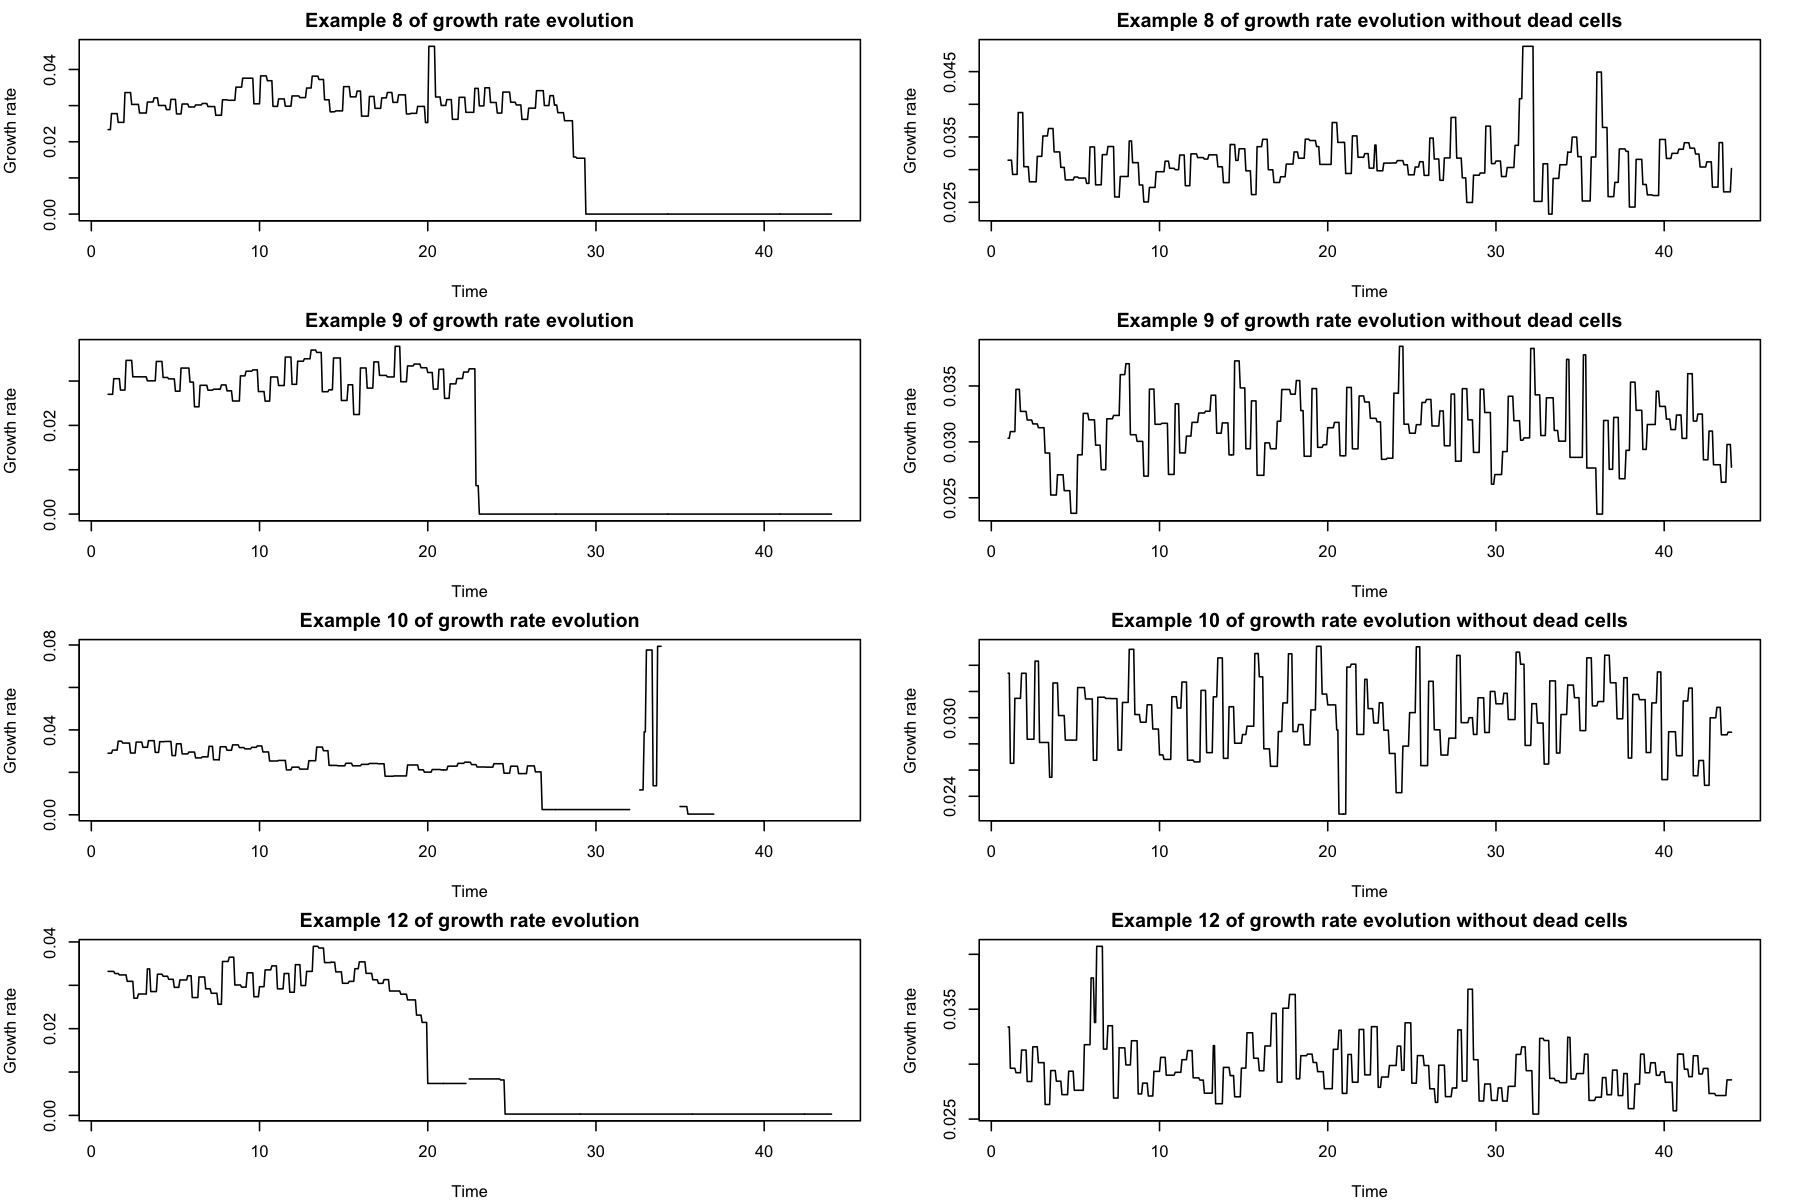

In [6]:
# Let us look at some examples:

par(mfrow=c(4,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)

for (i in c(8,9, 10,12)){
    plot(tmin:tmax*4/60, microMA_MutH_growthRates[tmin:tmax, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead[,i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution without dead cells"))
}

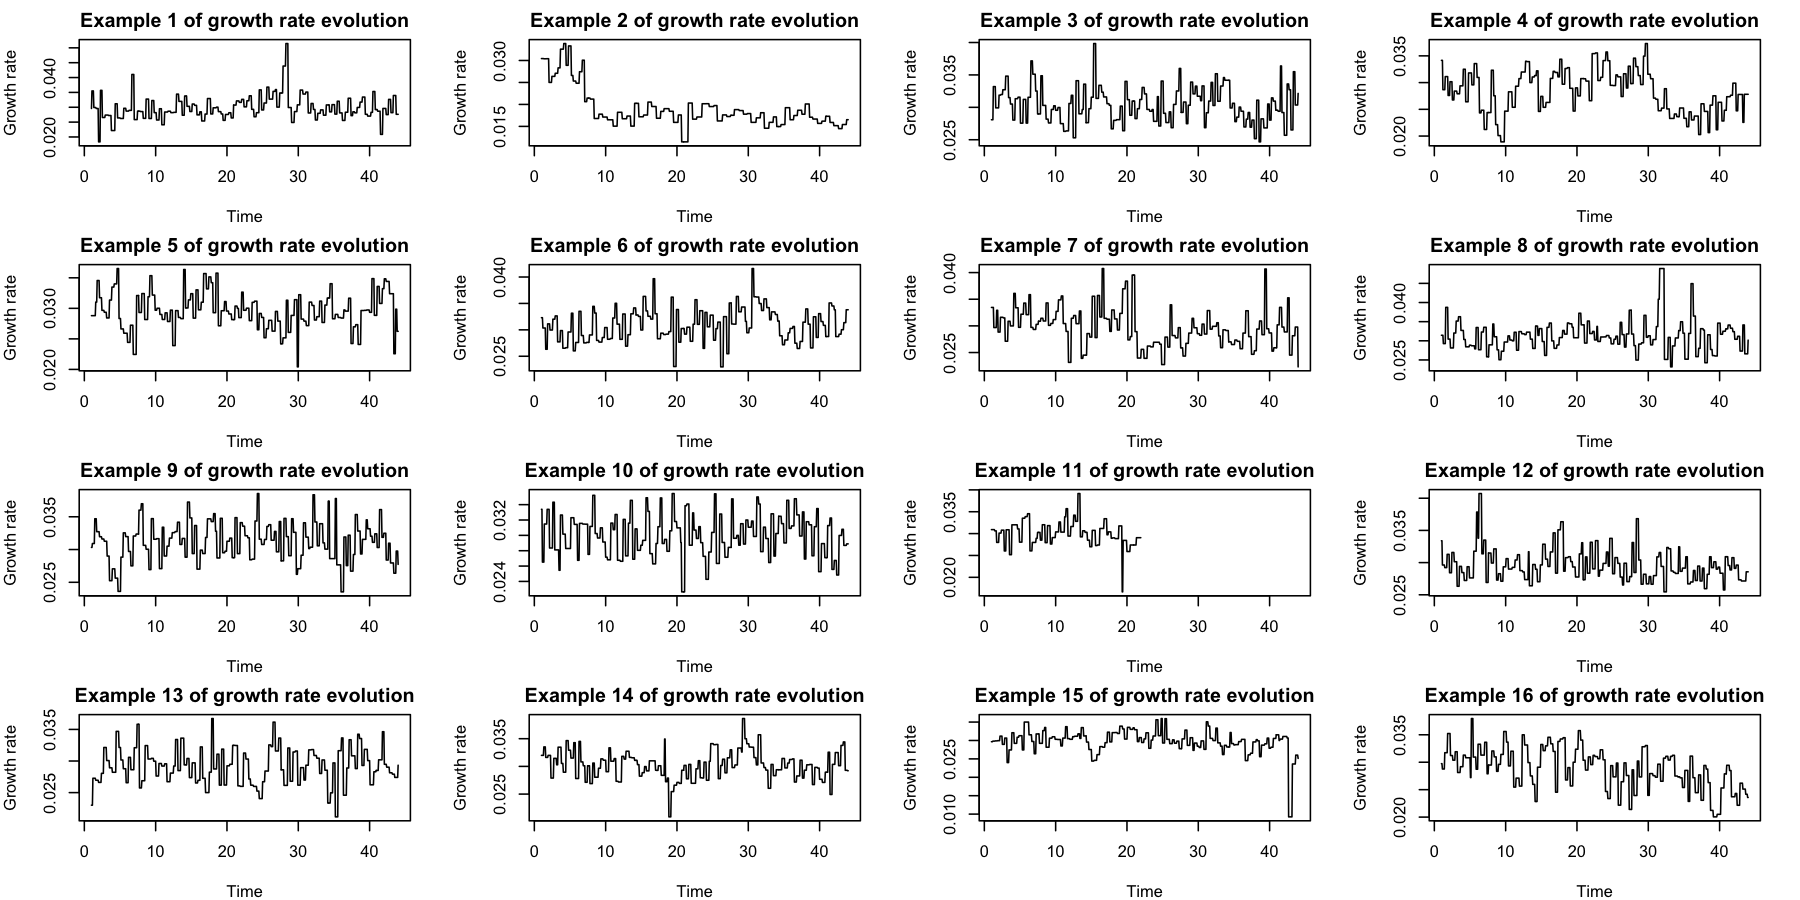

In [7]:
# Let us look at some examples:

par(mfrow=c(4,4), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:16){
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

Cette mise au point permet de supprimer environ 1/3 des cellules pour MutH. C'est beaucoup !

### Deletion of aberrant values

The segmentation errors generated by image analysis can create aberrant, very low or high growth rates. Therefore, we filtered our data in the following way. 

* For each channel and each generation, we **calculated the median of the growth rates for earlier generations (M bef ore ) and subsequent generations (M af ter )**. Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both M bef ore and M af ter or much smaller than both M bef ore and M af ter (Note that M bef ore and M af ter can be significantly different because of the occurrence of deleterious mutations). 

* **Therefore for each generation, we remove the value of the growth rate μ from the data if it di↵ers from both M af ter and M bef ore by more than a threshold value T. The value T was fixed at 30% of the average growth rate in the experiment**, corresponding to the mean+/ 2standard deviation of the variable μ M af ter (or equivalently μ M bef ore ; both variables follow a distribution that is well approximated by a gaussian). The datasets for all strains (WT mutH, mutT, and MF1 such as plotted in Figure 3A and Figure S8) were all filtered using the same procedure.


```
detect_aberrant_GR <- function(i, L){
    mu <- L[i]
    
    if (i>1){
        M_before <- median(L[max(1,i-1000):(i-1)], na.rm = T)
    }else{
        M_before <- mu
    }
    
    if (i<length(L)){
        M_after <- median(L[i+1:min(length(L),i+1000)], na.rm = T)
    }else{
        M_after <- mu
    }
    
    T <- 0.3*mean(L, na.rm = T) # threshold
    
    if (anyNA(c(mu, M_before, M_after))){ 
        return (TRUE) 
    }
    
    return((mu - M_before > T & mu - M_after > T)|(mu - M_before < -T & mu - M_after < -T))
}

microMA_MutH_growthRates_nodead_noab <- microMA_MutH_growthRates_nodead
for (i in 1:dim(microMA_MutH_growthRates_nodead_noab)[2]){
    L <- microMA_MutH_growthRates_nodead_noab[,i]
    microMA_MutH_growthRates_nodead_noab[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

microMA_WT_growthRates_RMdead_NAab <- microMA_WT_growthRates_RMdead
for (i in 1:dim(microMA_WT_growthRates_RMdead_NAab)[2]){
    L <- microMA_WT_growthRates_RMdead_NAab[,i]
    microMA_WT_growthRates_RMdead_NAab[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}

microMA_MutT_growthRates_nodead_noab <- microMA_MutT_growthRates_nodead
for (i in 1:dim(microMA_MutT_growthRates_nodead_noab)[2]){
    L <- microMA_MutT_growthRates_nodead_noab[,i]
    microMA_MutT_growthRates_nodead_noab[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}
microMA_MF1_growthRates_nodead_noab <- microMA_MF1_growthRates_nodead
for (i in 1:dim(microMA_MF1_growthRates_nodead_noab)[2]){
    L <- microMA_MF1_growthRates_nodead_noab[,i]
    microMA_MF1_growthRates_nodead_noab[sapply(1:length(L), detect_aberrant_GR, L = L),i] <- NA
}
```

In [8]:
detect_aberrant_GR <- function(df, width){
    # Rolling medians with a kernel aligned to the left or the right to each value
    M_before <- rollapply(df, width=width, median, align = 'left', na.rm = TRUE, fill = NA, partial = TRUE)
    M_after <- rollapply(df, width=width, median, align = 'right', na.rm = TRUE, fill = NA, partial = TRUE)

    # Threashold = mean growth rate (for non-zero values)
    T <- 0.3*colMeans(df, na.rm=TRUE)

    return((df - M_before > T & df - M_after > T)|(df - M_before < -T & df - M_after < -T))
}

remove_NA_lines <- function(GR){
    return(GR[!sapply(GR, function(x)all(is.na(x)))])
}

width=301

microMA_WT_growthRates_RMdead_NAab <- microMA_WT_growthRates_RMdead
microMA_WT_growthRates_RMdead_NAab[detect_aberrant_GR(microMA_WT_growthRates_RMdead_NAab, width)] <- NA
microMA_WT_growthRates_RMdead_NAab <- remove_NA_lines(microMA_WT_growthRates_RMdead_NAab)

microMA_MutH_growthRates_nodead_noab <- microMA_MutH_growthRates_nodead
microMA_MutH_growthRates_nodead_noab[detect_aberrant_GR(microMA_MutH_growthRates_nodead_noab, width)] <- NA
microMA_MutH_growthRates_nodead_noab <- remove_NA_lines(microMA_MutH_growthRates_nodead_noab)

microMA_MutT_growthRates_nodead_noab <- microMA_MutT_growthRates_nodead
microMA_MutT_growthRates_nodead_noab[detect_aberrant_GR(microMA_MutT_growthRates_nodead_noab, width)] <- NA
microMA_MutT_growthRates_nodead_noab <- remove_NA_lines(microMA_MutT_growthRates_nodead_noab)

microMA_MF1_growthRates_nodead_noab <- microMA_MF1_growthRates_nodead
microMA_MF1_growthRates_nodead_noab[detect_aberrant_GR(microMA_MF1_growthRates_nodead_noab, width)] <- NA
microMA_MF1_growthRates_nodead_noab <- remove_NA_lines(microMA_MF1_growthRates_nodead_noab)

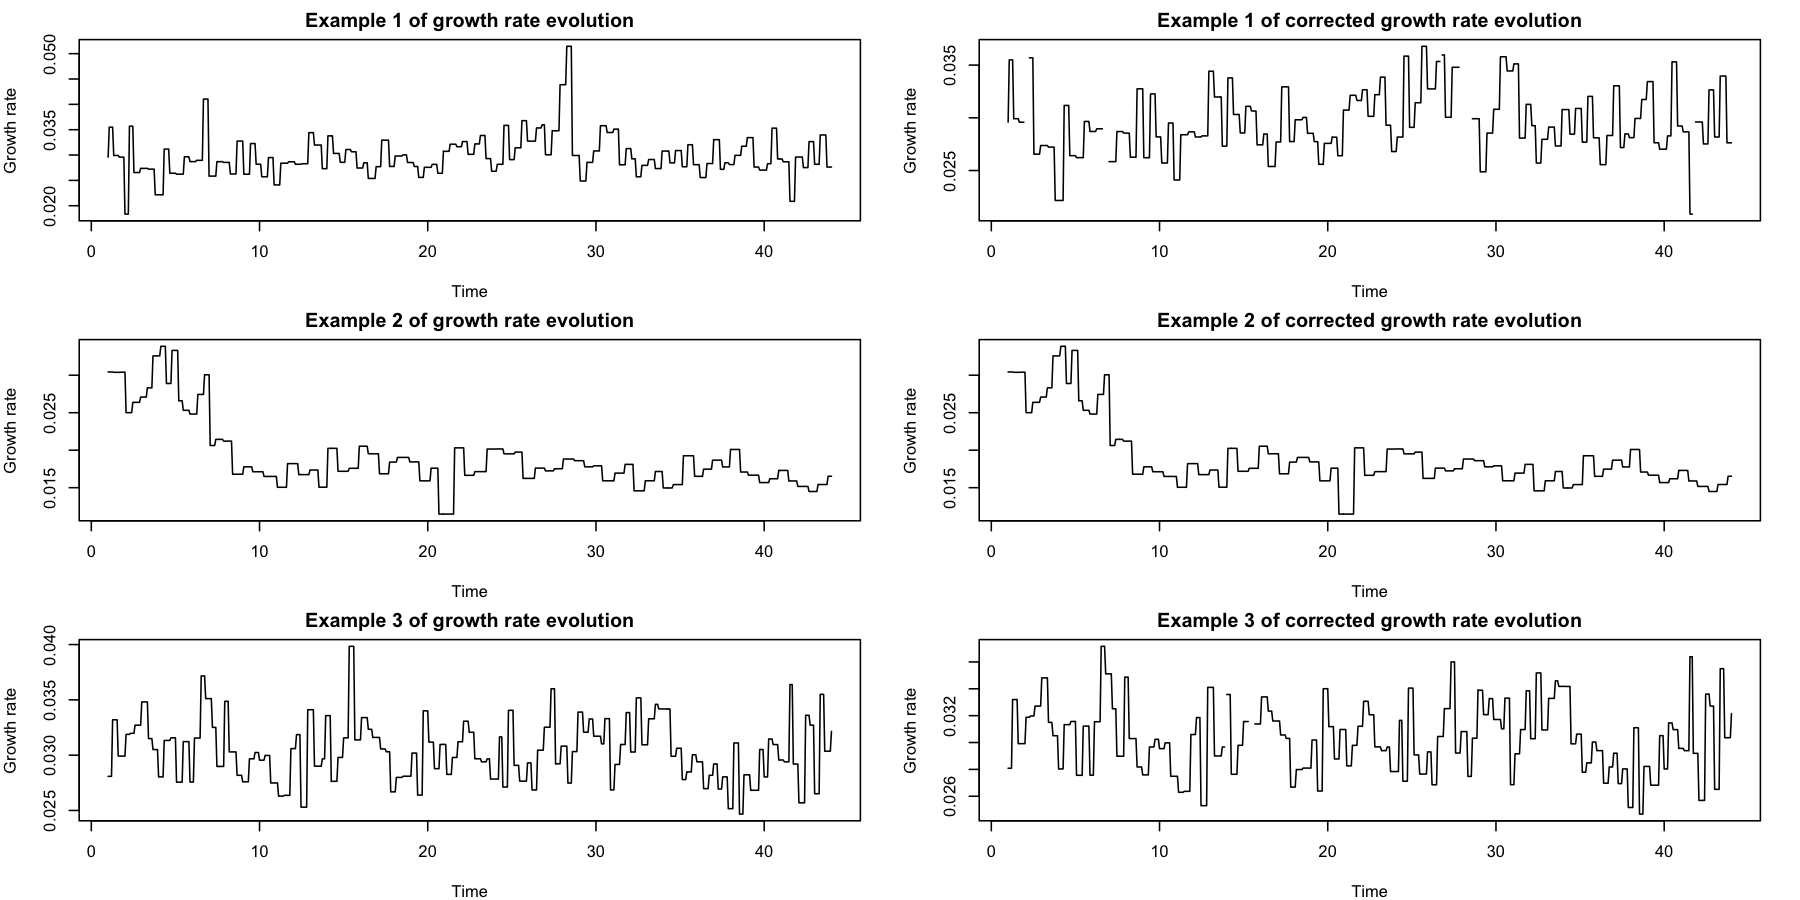

In [24]:
# Let us look at some examples:

par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:3){
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead_noab[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of corrected growth rate evolution"))
}

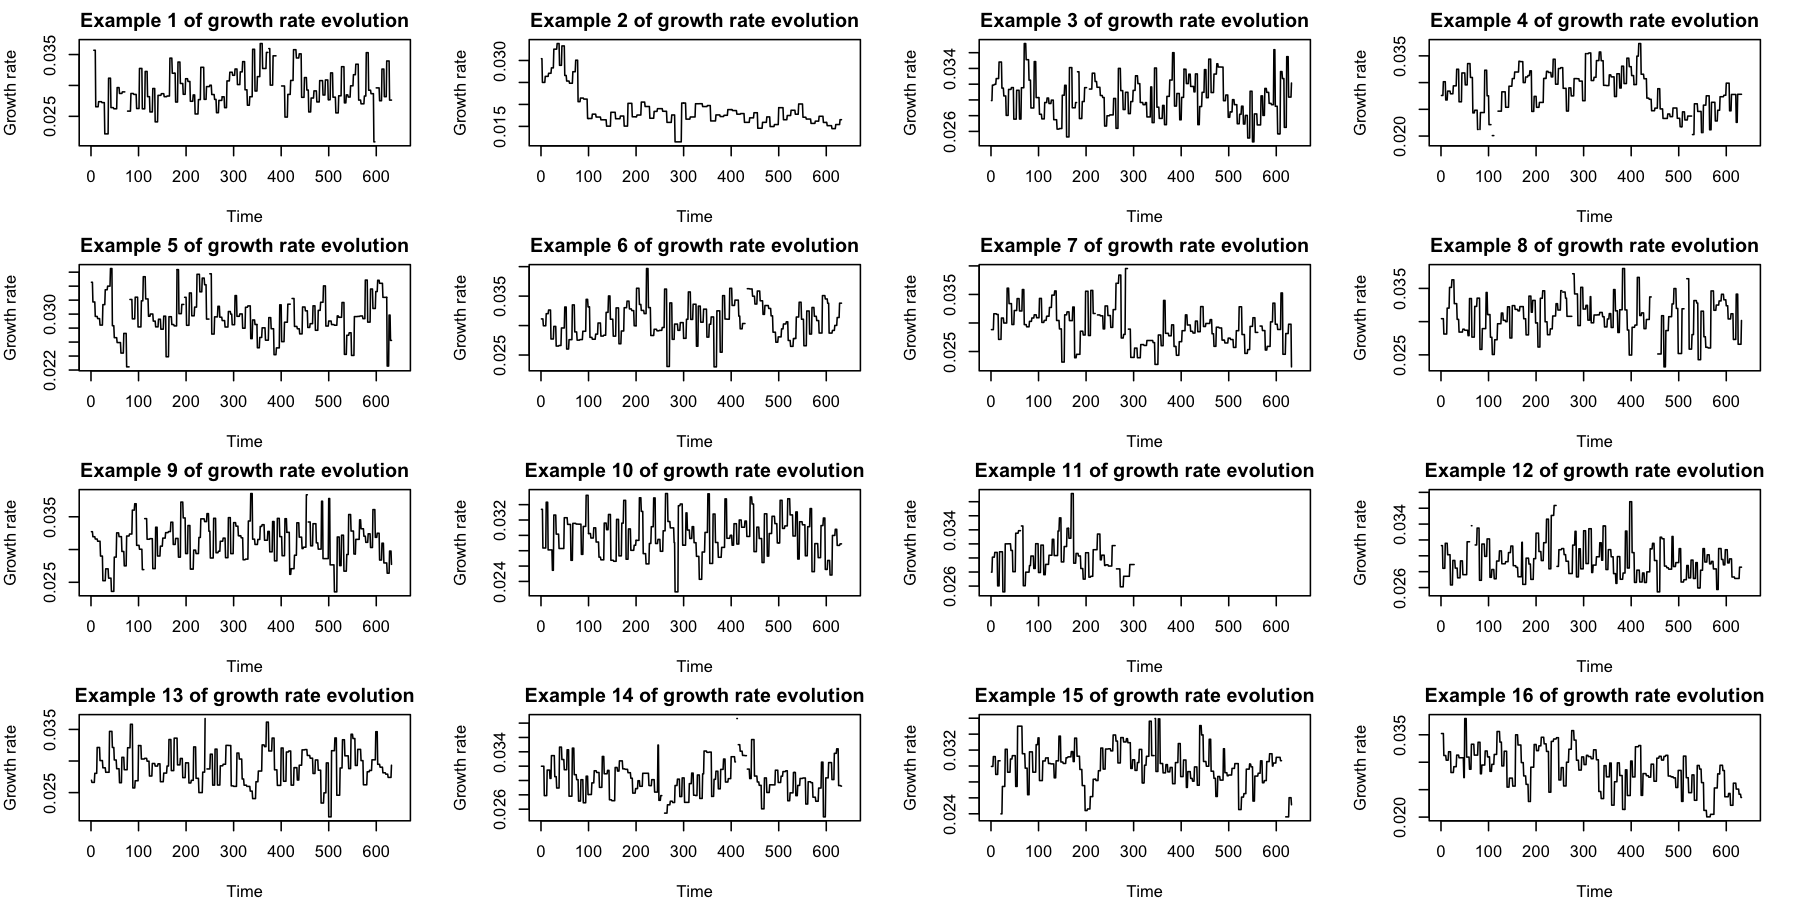

In [10]:
# Let us look at some examples:

par(mfrow=c(4,4), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:16){
    plot(microMA_MutH_growthRates_nodead_noab[tmin:tmax, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

In [11]:
write.csv2(microMA_WT_growthRates_RMdead_NAab, "Modified_data/data_microMA/dataset_microMA_WT_growthRates_RMdead_NAab.csv")
write.csv2(microMA_MutH_growthRates_nodead_noab, "Modified_data/data_microMA/dataset_microMA_MutH_growthRates_nodead_noab.csv")
write.csv2(microMA_MutT_growthRates_nodead_noab, "Modified_data/data_microMA/dataset_microMA_MutT_growthRates_nodead_noab.csv")
write.csv2(microMA_MF1_growthRates_nodead_noab, "Modified_data/data_microMA/dataset_microMA_MF1_growthRates_nodead_noab.csv")

### Estimation des moments

In [31]:
microMA_WT_growthRates_RMdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_WT_growthRates_RMdead_NAab.csv", row.names = 1)
microMA_MutH_growthRates_RMdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_MutH_growthRates_nodead_noab.csv", row.names = 1)
microMA_MutT_growthRates_RMdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_MutT_growthRates_nodead_noab.csv", row.names = 1)
microMA_MF1_growthRates_RMdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_MF1_growthRates_nodead_noab.csv", row.names = 1)

In [13]:
moment_expectation <- function(k, dataset){
  return (rowMeans(dataset**k, na.rm = T))
}

log_choose <- function(k, n, moments_expectations){
  return ((-1)**k*choose(n,k)*log(moments_expectations[,k]))
}

k_values=1:10
moments_expectations_clean_MutH <- data.frame(sapply(k_values, 
                                                     moment_expectation, 
                                                     dataset=microMA_MutH_growthRates_nodead_noab))
names(moments_expectations_clean_MutH) <- paste("k.", k_values, sep = "")

moments_expectations_clean_WT <- data.frame(sapply(k_values, 
                                                   moment_expectation, 
                                                   dataset=microMA_WT_growthRates_RMdead_NAab))
names(moments_expectations_clean_WT) <- paste("k.", k_values, sep = "")

moments_expectations_clean_MutT <- data.frame(sapply(k_values, 
                                                     moment_expectation, 
                                                     dataset=microMA_MutT_growthRates_nodead_noab))
names(moments_expectations_clean_MutT) <- paste("k.", k_values, sep = "")

moments_expectations_clean_MF1 <- data.frame(sapply(k_values, 
                                                    moment_expectation, 
                                                    dataset=microMA_MF1_growthRates_nodead_noab))
names(moments_expectations_clean_MF1) <- paste("k.", k_values, sep = "")

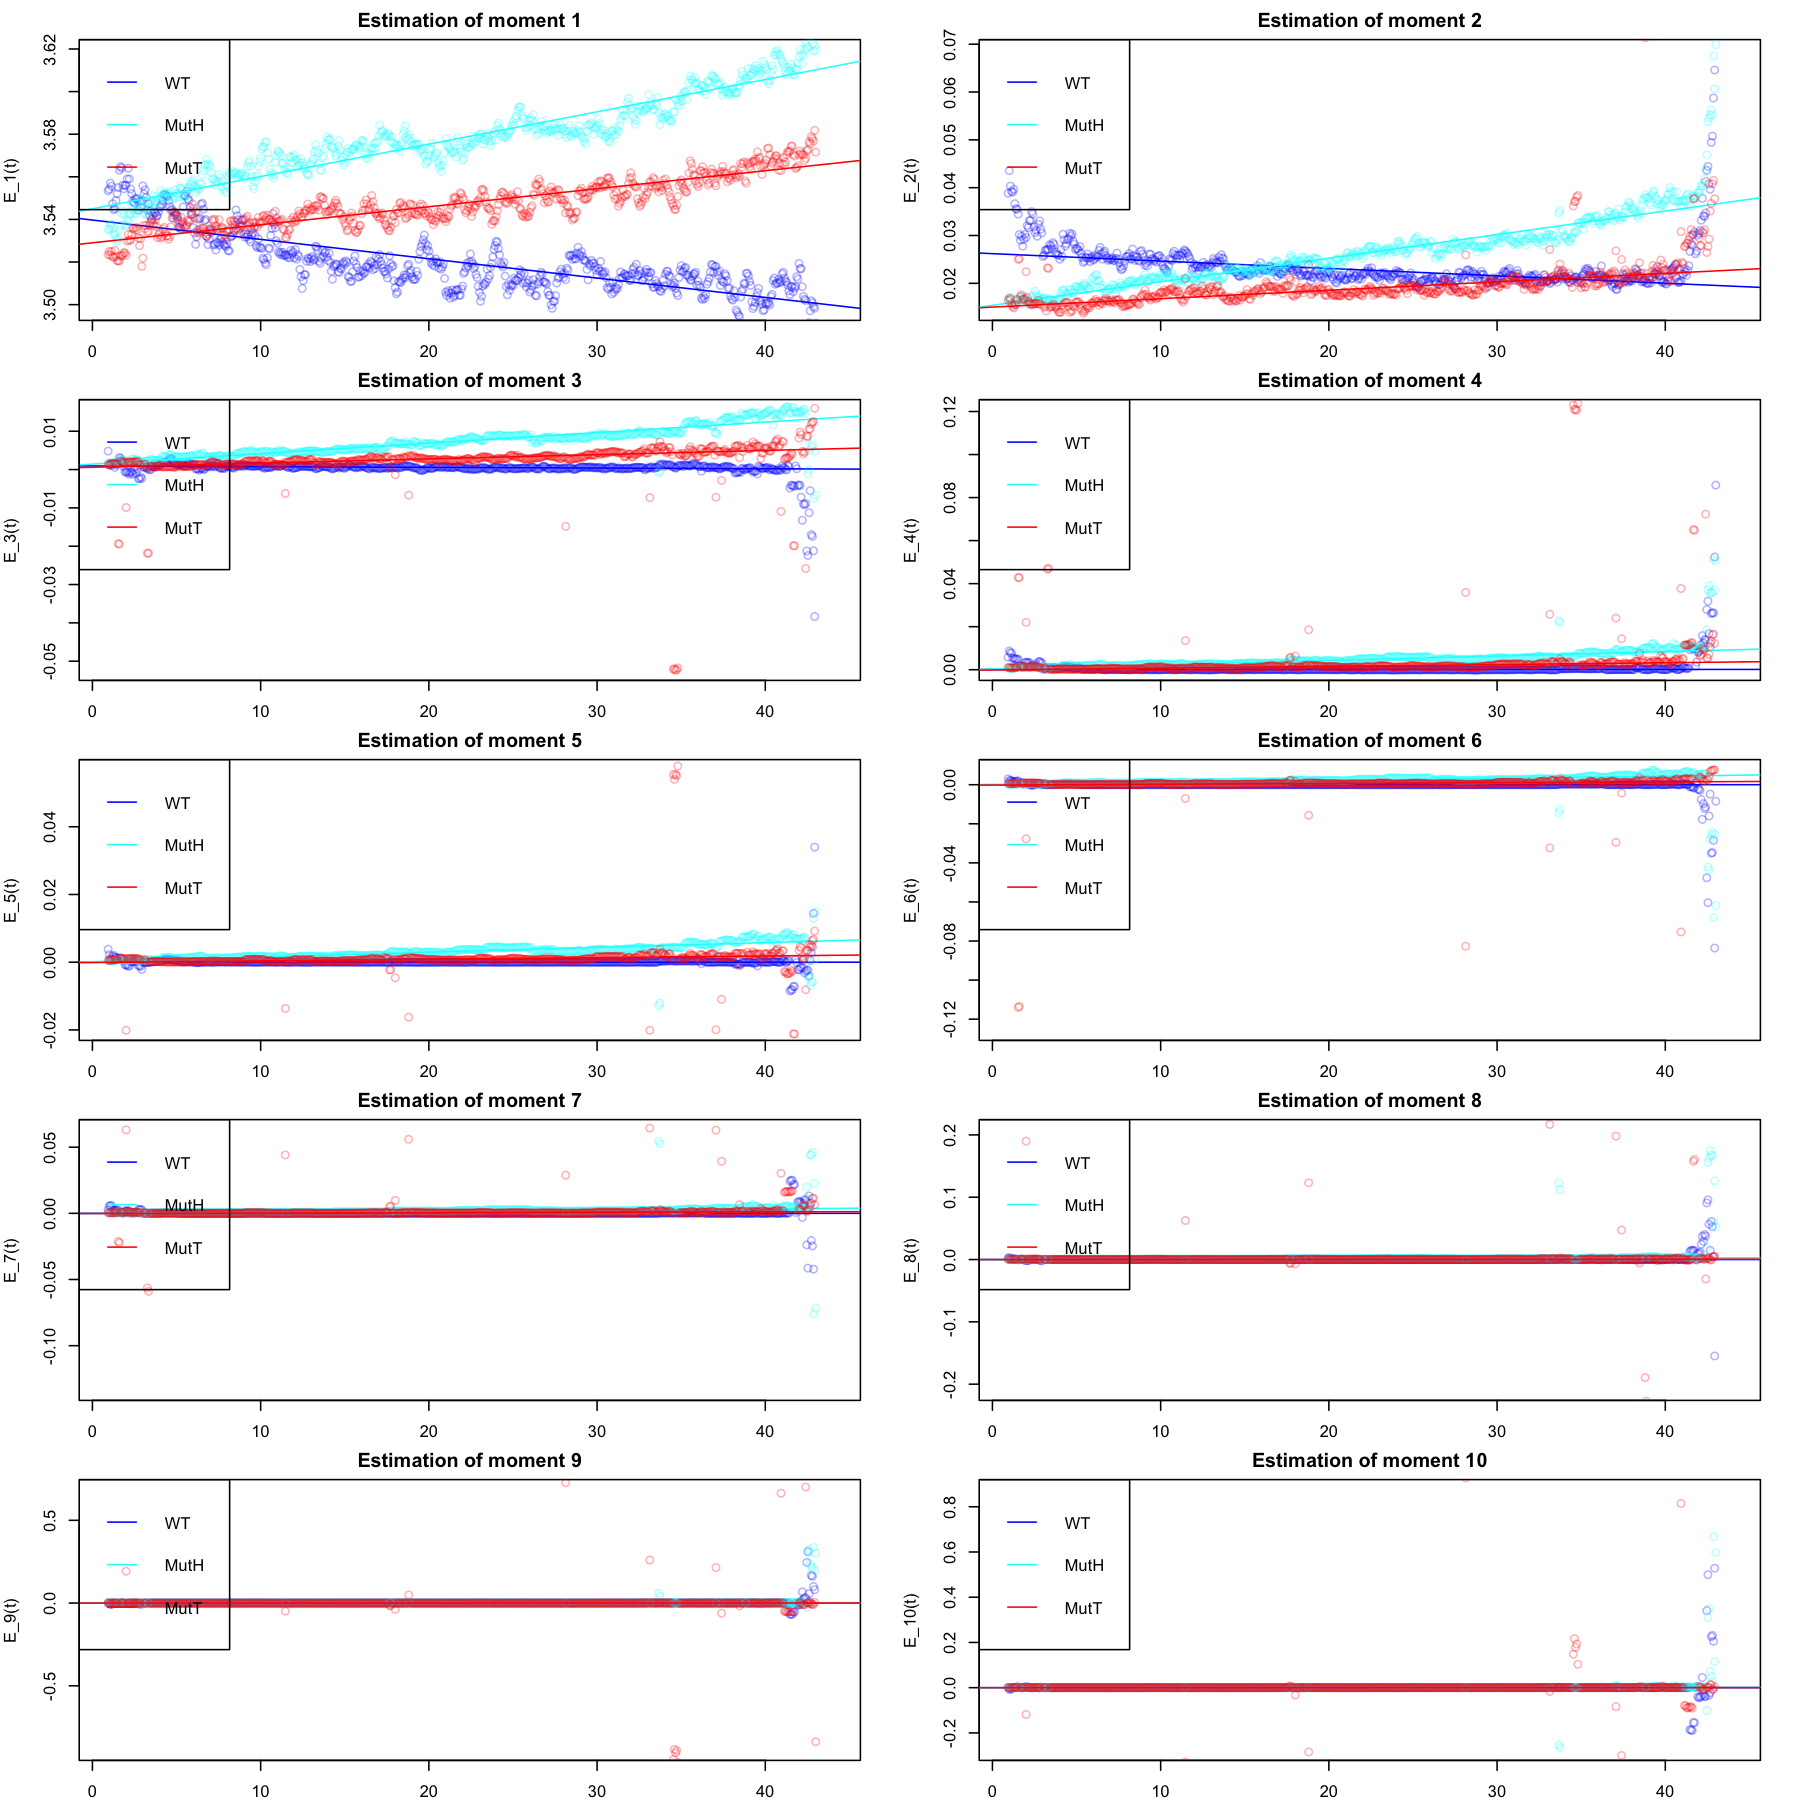

In [15]:
time_window=tmin:tmax
par(mfrow = c(5,2), mar = c(2, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

N <- 10
slopes <- data.frame(n = 1:N, 
                     slope_MutH = rep(NA,N),
                     slope_MutT = rep(NA,N), 
                     slope_MF1 = rep(NA,N),
                     slope_WT = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                       E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH[time_window,])),
                       E_nt_MutT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutT[time_window,])),
                       E_nt_WT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_WT[time_window,])))
    
    
    ### WT
    plot(x = df_n$time, 
         y = df_n$E_nt_WT, 
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = alpha("blue", 0.3),
         main = paste("Estimation of moment", n),
         ylim = quantile(df_n[,c("E_nt_WT", "E_nt_MutH", "E_nt_MutT")], c(0.005, 0.995), na.rm=T))
    
    lin_reg_WT <- rlm(E_nt_WT~time, data=df_n)
    abline(lin_reg_WT, col="blue", lwd=1)
    #slopes[n,7:11] <- c(summary(lin_reg_WT)$coefficients[2,c(1,2)]/60, summary(lin_reg_WT)$r.squared, mean(abs(resid(lin_reg_WT))), sqrt(mean(resid(lin_reg_WT)**2)))
    slopes$slope_WT[n] <- c(summary(lin_reg_WT)$coefficients[2,c(1)]/60)
    
    
    
    ### MutH
    points(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           col = alpha("cyan", 0.3))
    
    lin_reg_MutH <- rlm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="cyan", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutH[n] <- c(summary(lin_reg_MutH)$coefficients[2,c(1)]/60)
    
        
    ### MutT
    points(x = df_n$time, 
           y = df_n$E_nt_MutT,
           col = alpha("red", 0.3))
    
    lin_reg_MutT <- rlm(E_nt_MutT~time, data=df_n)
    abline(lin_reg_MutT, col="red", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutT[n] <- c(summary(lin_reg_MutT)$coefficients[2,c(1)]/60)
    
    
    legend("topleft", legend = c("WT", "MutH", "MutT"), col=c("blue", "cyan", "red"), lty=1, seg.len = 1, text.width=3)
    
}

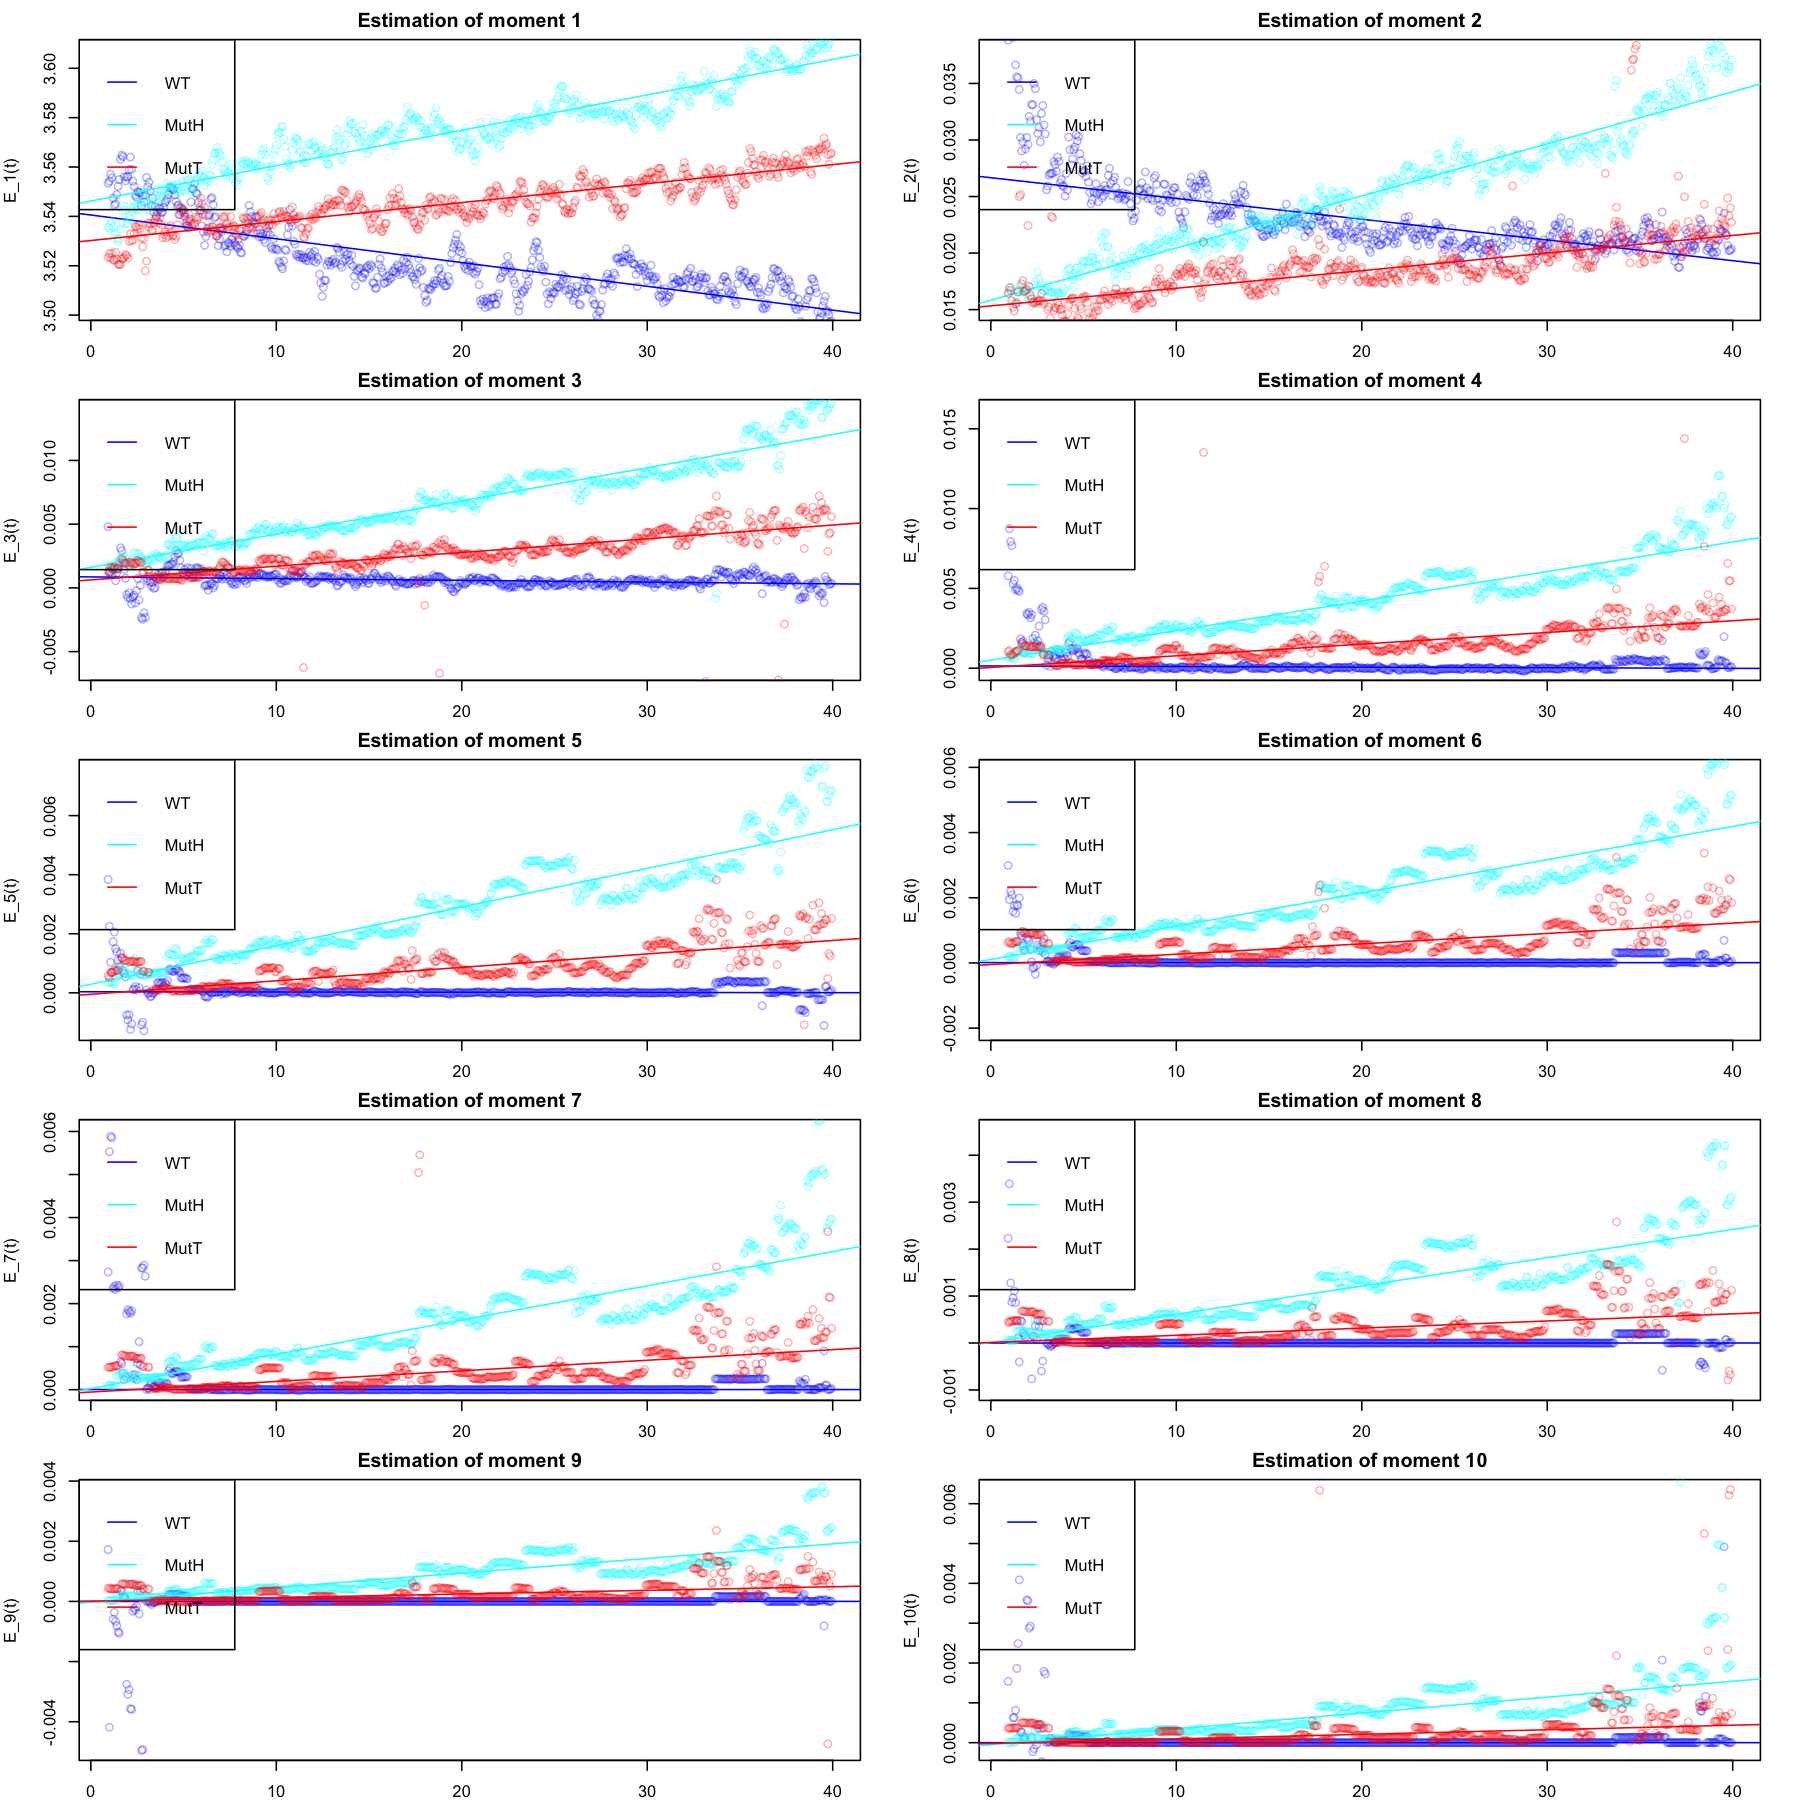

In [27]:
time_window=tmin:(tmax-4*15)
par(mfrow = c(5,2), mar = c(2, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

N <- 10
#slopes <- data.frame(n = 1:N,
#                     slope_MutH = rep(NA,N), std_err_MutH = rep(NA,N), r2_MutH = rep(NA,N), resid_L1_MutH = rep(NA,N), resid_L2_MutH = rep(NA,N), 
#                     slope_WT = rep(NA,N), std_err_WT = rep(NA,N), r2_WT = rep(NA,N), resid_L1_WT = rep(NA,N), resid_L2_WT = rep(NA,N))
slopes <- data.frame(n = 1:N, 
                    slope_MutH = rep(NA,N),
                    slope_MutT = rep(NA,N), 
                    slope_MF1 = rep(NA,N),
                    slope_WT = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH[time_window,])),
                     E_nt_MutT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutT[time_window,])),
                     E_nt_WT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_WT[time_window,])))
    
    
    ### WT
    plot(x = df_n$time, 
         y = df_n$E_nt_WT, 
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = alpha("blue", 0.3),
         main = paste("Estimation of moment", n),
         ylim = quantile(df_n[,c("E_nt_WT", "E_nt_MutH", "E_nt_MutT")], c(0.01, 0.99), na.rm=T))
    
    lin_reg_WT <- rlm(E_nt_WT~time, data=df_n)
    abline(lin_reg_WT, col="blue", lwd=1)
    #slopes[n,7:11] <- c(summary(lin_reg_WT)$coefficients[2,c(1,2)]/60, summary(lin_reg_WT)$r.squared, mean(abs(resid(lin_reg_WT))), sqrt(mean(resid(lin_reg_WT)**2)))
    slopes$slope_WT[n] <- c(summary(lin_reg_WT)$coefficients[2,c(1)]/60)
    
    
    
    ### MutH
    points(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           col = alpha("cyan", 0.3))
    
    lin_reg_MutH <- rlm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="cyan", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutH[n] <- c(summary(lin_reg_MutH)$coefficients[2,c(1)]/60)
    
        
    ### MutT
    points(x = df_n$time, 
           y = df_n$E_nt_MutT,
           col = alpha("red", 0.3))
    
    lin_reg_MutT <- rlm(E_nt_MutT~time, data=df_n)
    abline(lin_reg_MutT, col="red", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutT[n] <- c(summary(lin_reg_MutT)$coefficients[2,c(1)]/60)
    
    
    legend("topleft", legend = c("WT", "MutH", "MutT"), col=c("blue", "cyan", "red"), lty=1, seg.len = 1, text.width=3)
    
}

![](Img/Moments_estimation.png)

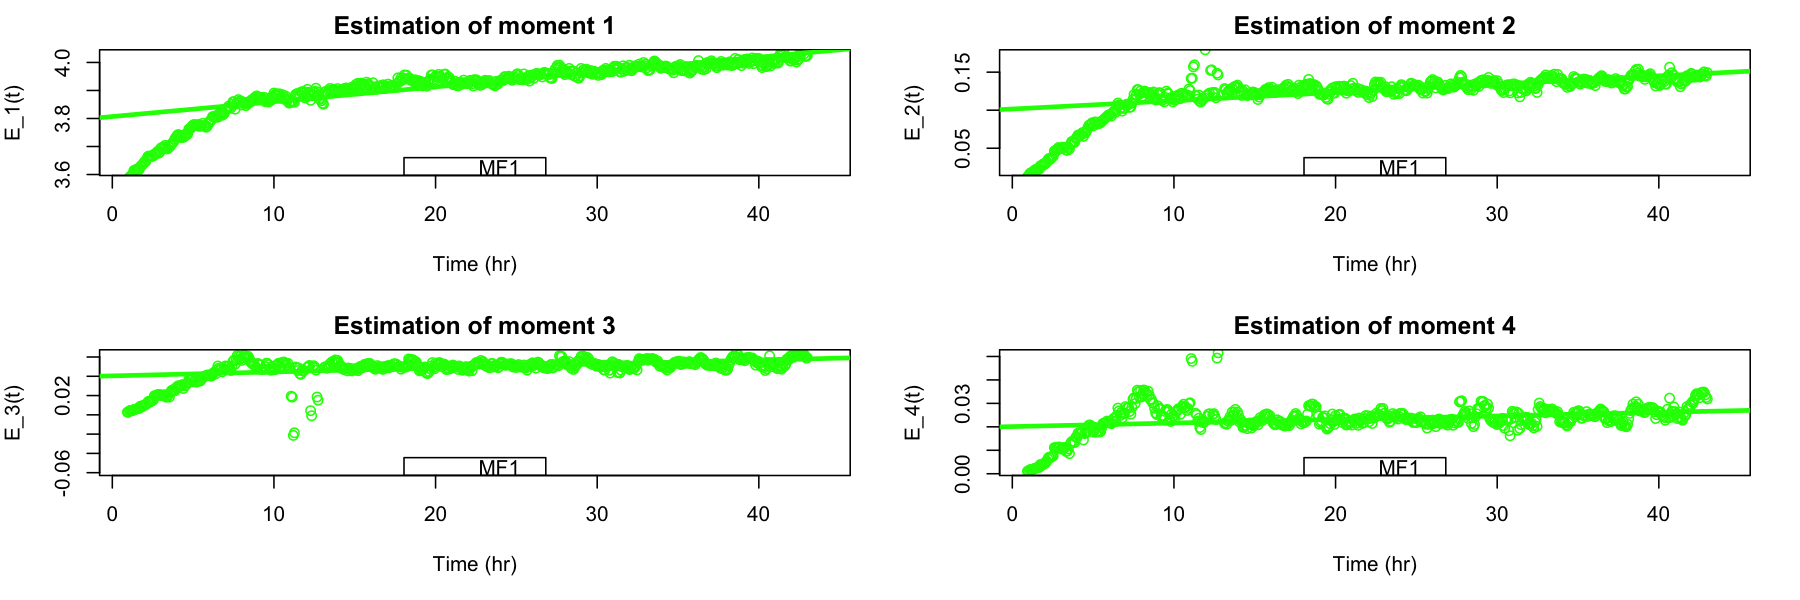

In [28]:
time_window=tmin:(tmax)
par(mfrow = c(2,2), mar = c(5, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 150)

for (n in 1:4){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_MF1 = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MF1[time_window,])))

    
    ### MF1
    plot(x = df_n$time, 
         y = df_n$E_nt_MF1,
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""), 
         ylim = quantile(df_n$E_nt_MF1, c(0.01, 0.99), na.rm=T),
         col = "green",
         main = paste("Estimation of moment", n))
    
    lin_reg_MF1 <- rlm(E_nt_MF1~time, data=df_n)
    abline(lin_reg_MF1, col="green", lwd=3)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MF1[n] <- c(summary(lin_reg_MF1)$coefficients[2,c(1)]/60)

    
  legend("bottom", legend = c("MF1"), col=c("green"), seg.len = 1, text.width=3)
    
}

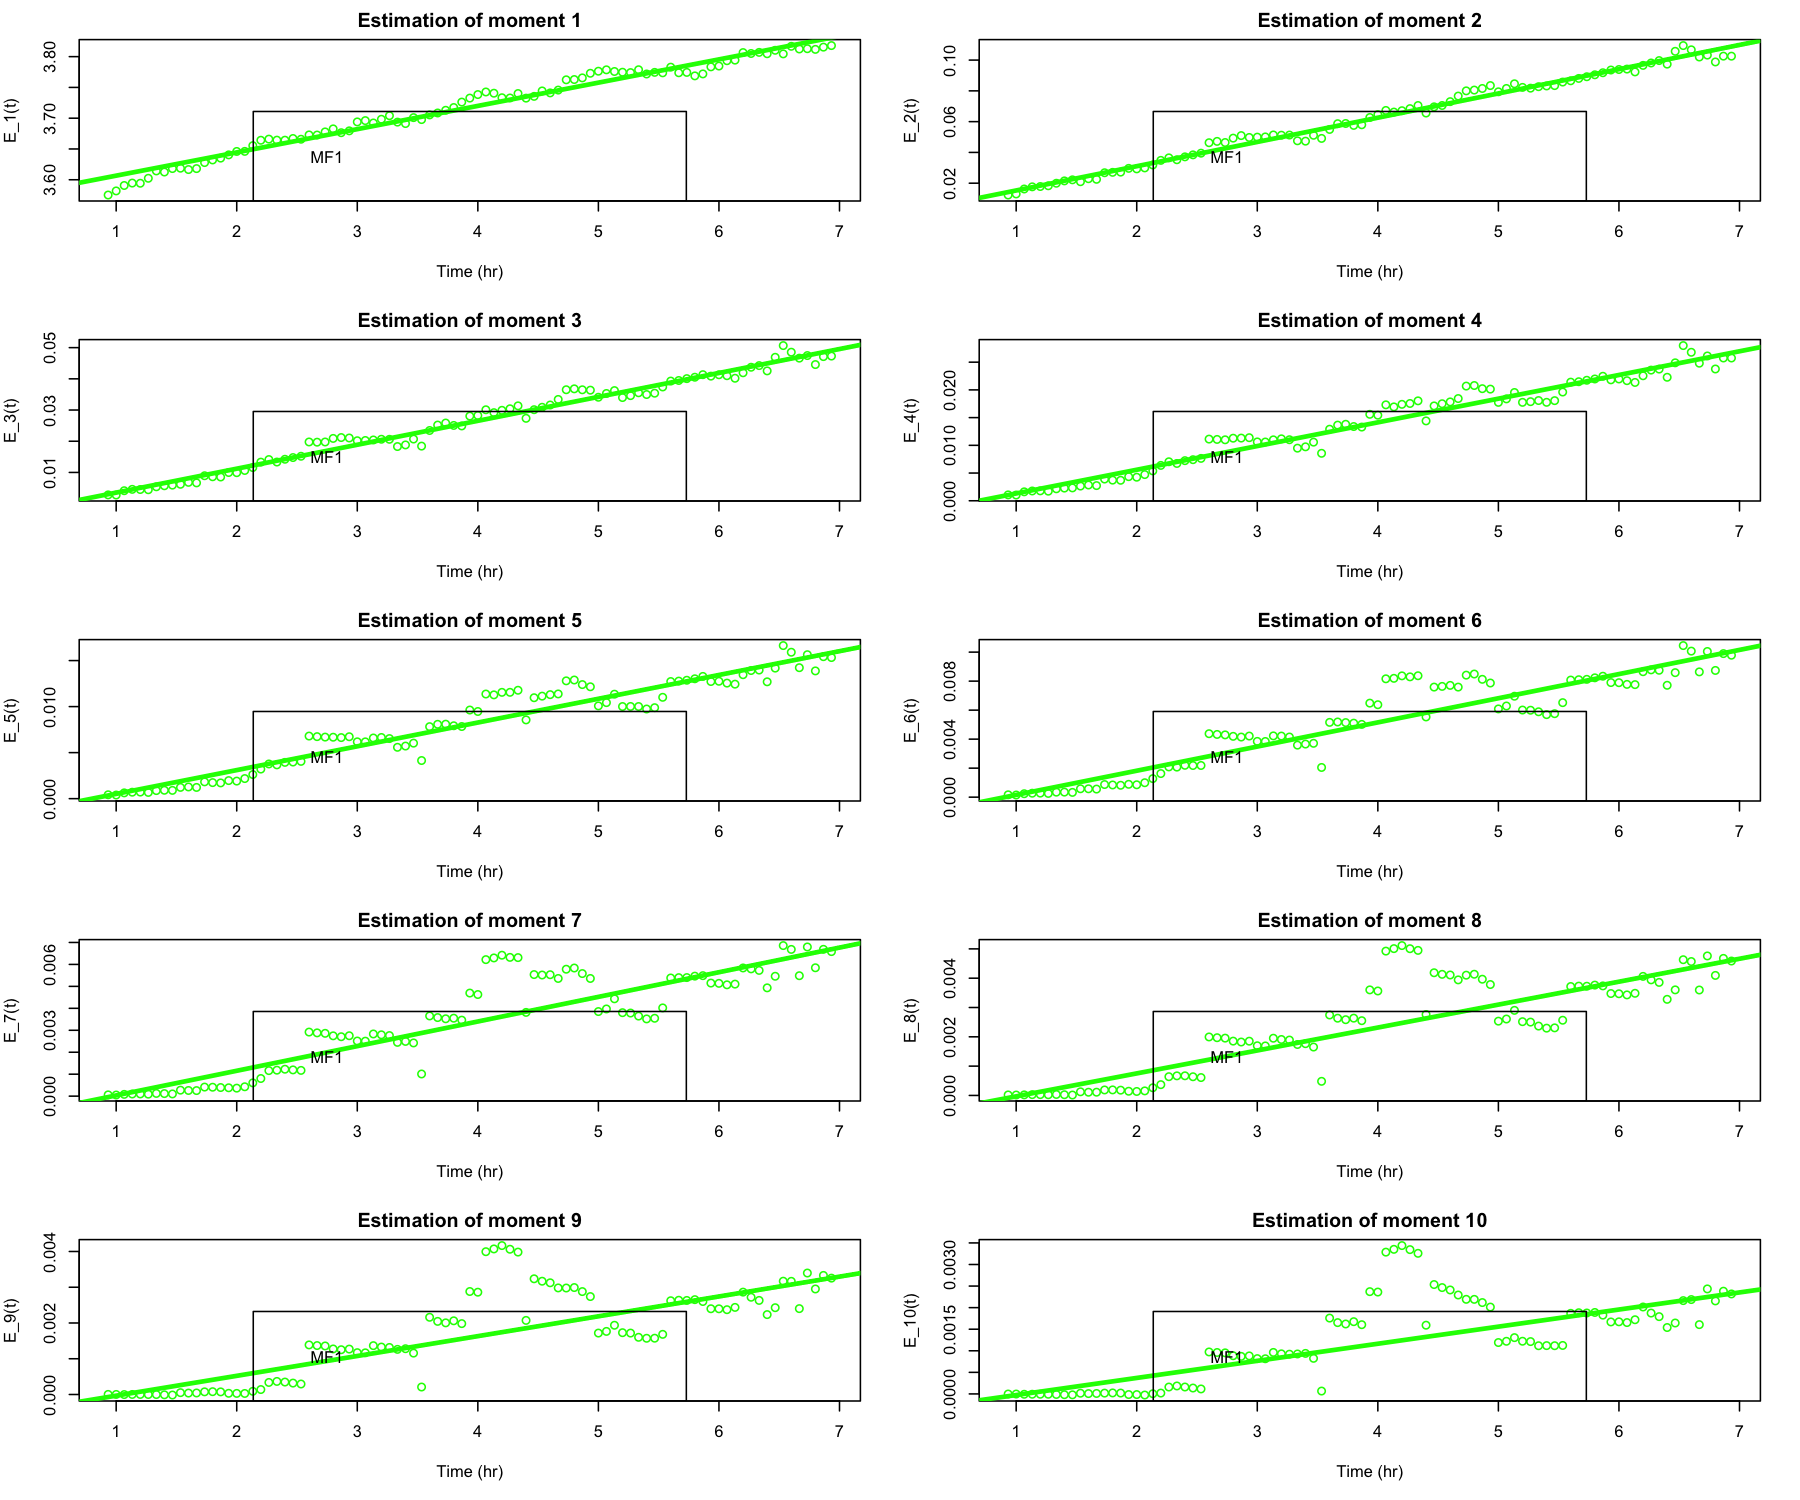

In [29]:
time_window=tmin:(tmax-37*15)
par(mfrow = c(5,2), mar = c(5, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_MF1 = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MF1[time_window,])))

    
    ### MF1
    plot(x = df_n$time, 
         y = df_n$E_nt_MF1,
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = "green",
         main = paste("Estimation of moment", n))
    
    lin_reg_MF1 <- rlm(E_nt_MF1~time, data=df_n)
    abline(lin_reg_MF1, col="green", lwd=3)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MF1[n] <- c(summary(lin_reg_MF1)$coefficients[2,c(1)]/60)

    
  legend("bottom", legend = c("MF1"), col=c("green"), seg.len = 1, text.width=3)
    
}

In [30]:
mult_factor = c(10**5, 10**6, 10**6, rep(10**7, 7))
cbind(slopes[1], mult_factor=mult_factor, signif(slopes[-1], digits=2)*mult_factor)

n  mult_factor slope_MutH slope_MutT slope_MF1 slope_WT
1   1 1e+05        2.4        1.3        63       -1.60000
2   2 1e+06        7.7        2.6       260       -3.10000
3   3 1e+06        4.3        1.8       130       -0.23000
4   4 1e+07       31.0       12.0       710       -0.65000
5   5 1e+07       22.0        7.6       430       -0.14000
6   6 1e+07       17.0        5.3       280       -0.00890
7   7 1e+07       13.0        4.1       190       -0.00460
8   8 1e+07       10.0        2.5       130        0.00380
9   9 1e+07        8.1        2.0        93        0.00520
10 10 1e+07        6.6        1.9        66       -0.00029

 ![](Img/Slope_values.png)

## Traitement des données : conserver canaux avec cellules mortes

Full relevant text:

* The segmentation errors generated by image analysis can create aberrant, very low or high growth rates. Therefore, we filtered our data in the following way. For each channel and each generation, we calculated the median of the growth rates for earlier generations (M bef ore ) and subsequent generations (M af ter ). Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both M bef ore and M af ter or much smaller than both M bef ore and M af ter (Note that M bef ore and M af ter can be significantly different because of the occurrence of deleterious mutations). Therefore for each generation, we remove the value of the growth rate μ from the data if it di↵ers from both M af ter and M bef ore by more than a threshold value T. The value T was fixed at 30% of the average growth rate in the experiment, corresponding to the mean+/ 2standard deviation of the variable μ M af ter (or equivalently μ M bef ore ; both variables follow a distribution that is well approximated by a gaussian). The datasets for all strains (WT mutH, mutT, and MF1 such as plotted in Figure 3A and Figure S8) were all filtered using the same procedure. **was done afterwards**

* In order to eliminate any image analysis errors that could bias our results and would not have been removed by this filtering procedure, we selected all the channels where a growth rate smaller than 0.015 was detected and systematically checked by visual inspection cell segmentation and tracking on all the images corresponding to this channel. Therefore, small growth rate values are all valid measurements. **Can't be done**

* Death of slowly growing cells induces noise in DFE estimation (figure S14). Therefore, to estimate the DFE’s first moments (figure 3C and table S3) we used a subset of the data, restricted in time and containing only cells that do not die on this restricted time window (time points before 40 hours, only channels where the mother cell is still alive at 44 hours). For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data. We checked that the results obtained through this automatic procedure are identical to those obtained when removing dead cells detected by visual inspection of the phase contrast images, as shown in table S8 for a representative mutH experiment. **Was done first (see email)**

### Deletion of slowly growing/dead cells
* Death of slowly growing cells induces noise in DFE estimation (figure S14). Therefore, to estimate the DFE’s first moments (figure 3C and table S3) we used a subset of the data, restricted in time and containing only cells that do not die on this restricted time window (time points before 40 hours, only channels where the mother cell is still alive at 44 hours). **For selecting such data we use an automatic procedure. If the growth rate of a cell is below 0.003 (10% of its initial value) during more than 80 minutes, the cell and its potential descendants are removed from the data**. We checked that the results obtained through this automatic procedure are identical to those obtained when removing dead cells detected by visual inspection of the phase contrast images, as shown in table S8 for a representative mutH experiment. 

Code alternatif, qui ne prend pas en compte les NAs (sinon on peut supprimer des cellules avec juste une série de NAs) et n'impose pas la continité sur les 80h en dessous du seuil.

In [ ]:
plot(tmin:tmax*4/60, microMA_MutH_growthRates[tmin:tmax, 12], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",12,"of growth rate evolution"))

In [32]:
tmin=1*15
tmax=44*15
threshold <- 0.003
keep_cells <- TRUE  # wether to keep early cells even if the mother cell dies later on

first_slow_cell <- function(x, threshold){
    return (min(which(x<threshold), na.rm=T))
}
remove_slow_GR <- function(GR, threshold, keep_cells, tmin, tmax){
     # Identify channels with >80h of slow growth (dead mother cell)
     slow_channels <- which(colSums(GR[1:(tmax+20),]<threshold, na.rm=T)>20)
     
     if (keep_cells){
         d <- dim(GR[slow_channels])
         # Find the first slow growth rate time and set all following growth rates to NA
         first_slow_time <- sapply(GR[slow_channels], first_slow_cell, threshold)
         GR_to_remove <- sapply(first_slow_time, function(t){matrix(1:d[1], d) >= max(t-10, 0)})
         GR[slow_channels][GR_to_remove] <- NA
    }else{
         GR <- GR[-slow_channels]
    }
    print(paste("slow_channels :", length(slow_channels))); print(dim(GR))
    return (GR[tmin:tmax,])
 }

print("WT")
microMA_WT_growthRates_NAdead <- remove_slow_GR(microMA_WT_growthRates, threshold, keep_cells, tmin, tmax)

print("MutH")
microMA_MutH_growthRates_nodead <- remove_slow_GR(microMA_MutH_growthRates, threshold, keep_cells, tmin, tmax)

print("MutT")
microMA_MutT_growthRates_nodead <- remove_slow_GR(microMA_MutT_growthRates, threshold, keep_cells, tmin, tmax)

print("MF1")
microMA_MF1_growthRates_nodead <- remove_slow_GR(microMA_MF1_growthRates, threshold, keep_cells, tmin, tmax)

[1] "WT"
[1] "slow_channels : 198"
[1]  999 1251
[1] "MutH"
[1] "slow_channels : 650"
[1] 1000 1476
[1] "MutT"
[1] "slow_channels : 554"
[1]  946 1427
[1] "MF1"
[1] "slow_channels : 659"
[1] 668 838


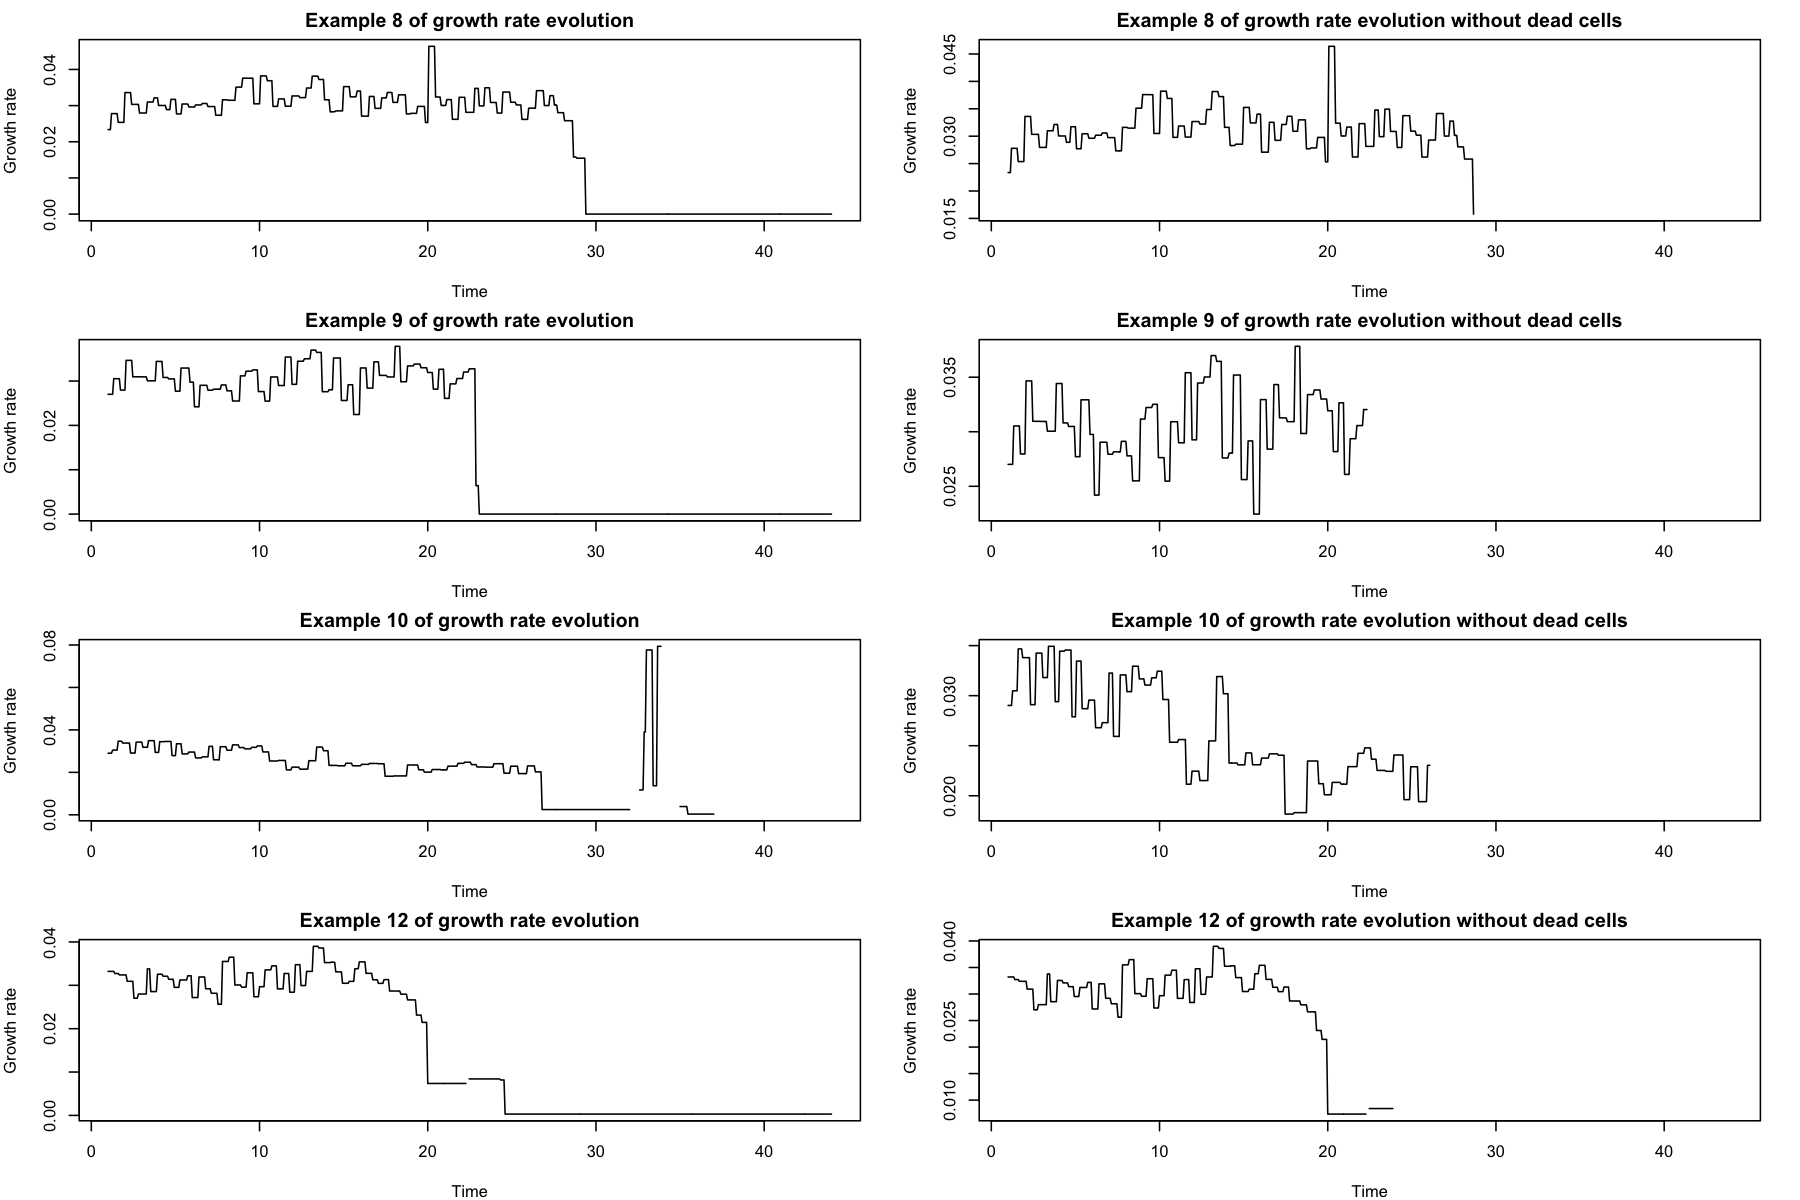

In [33]:
# Let us look at some examples:

par(mfrow=c(4,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)

for (i in c(8,9, 10,12)){
    plot(tmin:tmax*4/60, microMA_MutH_growthRates[tmin:tmax, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead[,i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution without dead cells"))
}

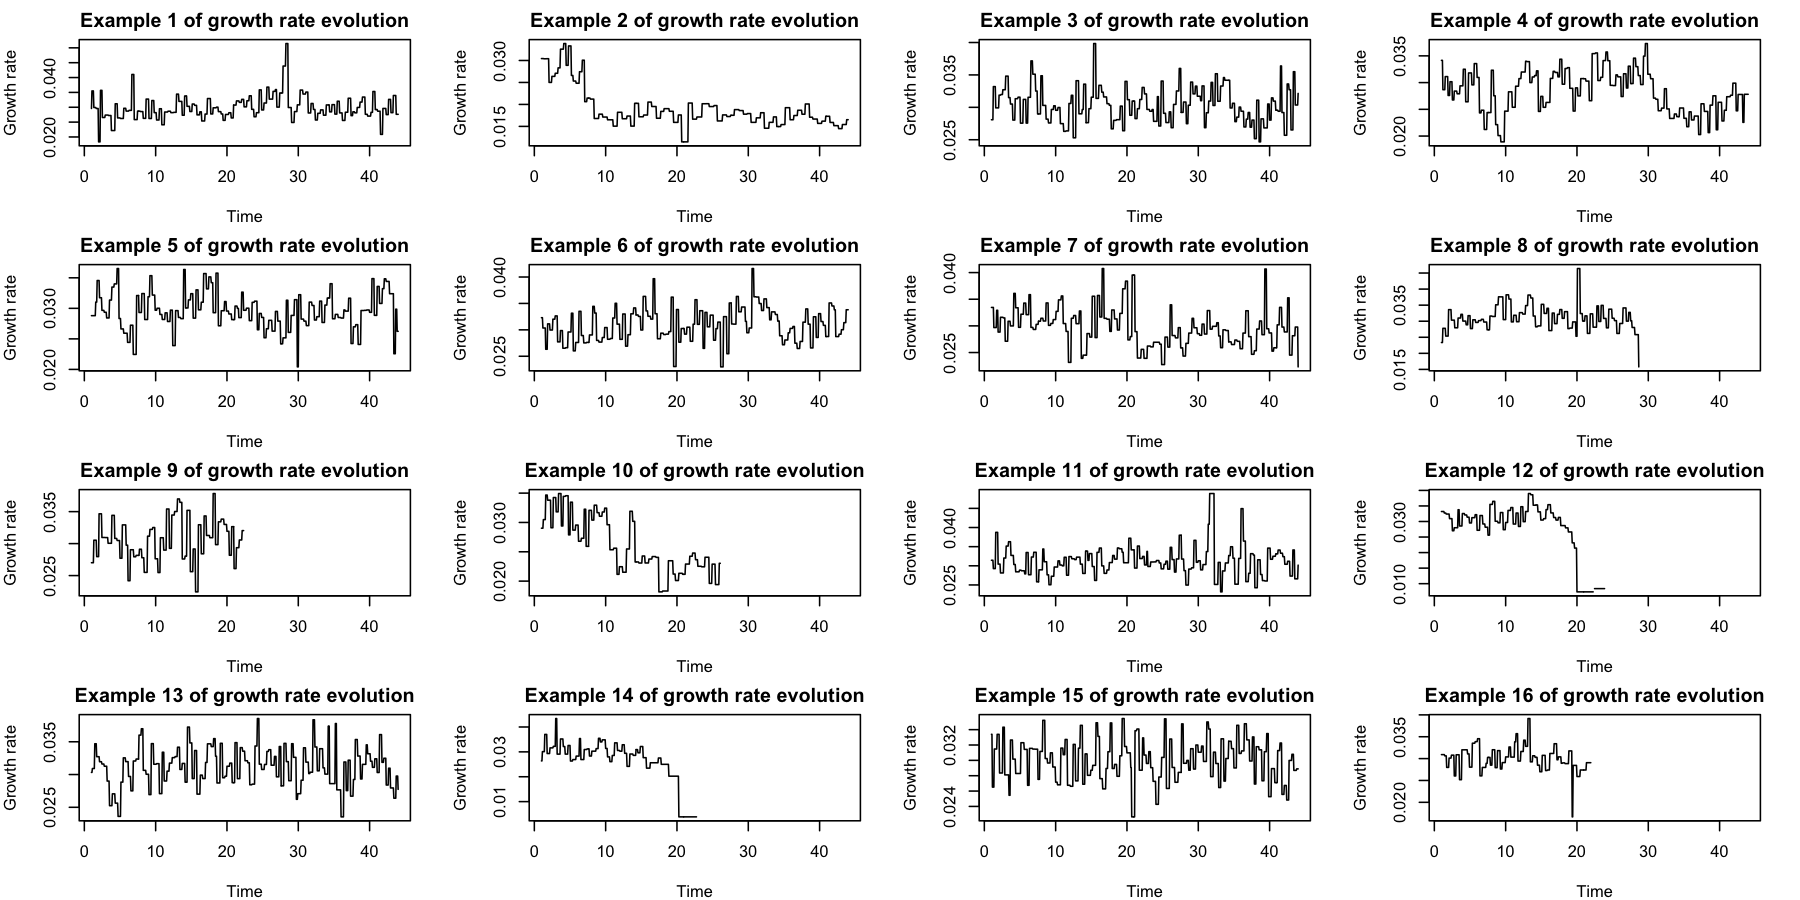

In [34]:
# Let us look at some examples:

par(mfrow=c(4,4), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:16){
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

### Deletion of aberrant values

The segmentation errors generated by image analysis can create aberrant, very low or high growth rates. Therefore, we filtered our data in the following way. 

* For each channel and each generation, we **calculated the median of the growth rates for earlier generations (M bef ore ) and subsequent generations (M af ter )**. Growth rate estimates that are clearly aberrant (as confirmed by visual inspection of images) are either much larger than both M bef ore and M af ter or much smaller than both M bef ore and M af ter (Note that M bef ore and M af ter can be significantly different because of the occurrence of deleterious mutations). 

* **Therefore for each generation, we remove the value of the growth rate μ from the data if it di↵ers from both M af ter and M bef ore by more than a threshold value T. The value T was fixed at 30% of the average growth rate in the experiment**, corresponding to the mean+/ 2standard deviation of the variable μ M af ter (or equivalently μ M bef ore ; both variables follow a distribution that is well approximated by a gaussian). The datasets for all strains (WT mutH, mutT, and MF1 such as plotted in Figure 3A and Figure S8) were all filtered using the same procedure.


In [35]:
detect_aberrant_GR <- function(df, width){
    # Rolling medians with a kernel aligned to the left or the right to each value
    M_before <- rollapply(df, width=width, median, align = 'left', na.rm = TRUE, fill = NA, partial = TRUE)
    M_after <- rollapply(df, width=width, median, align = 'right', na.rm = TRUE, fill = NA, partial = TRUE)

    # Threashold = mean growth rate (for non-zero values)
    T <- 0.3*colMeans(df, na.rm=TRUE)

    return((df - M_before > T & df - M_after > T)|(df - M_before < -T & df - M_after < -T))
}

remove_NA_lines <- function(GR){
    return(GR[!sapply(GR, function(x)all(is.na(x)))])
}

width=301

microMA_WT_growthRates_NAdead_NAab <- microMA_WT_growthRates_NAdead
microMA_WT_growthRates_NAdead_NAab[detect_aberrant_GR(microMA_WT_growthRates_NAdead_NAab, width)] <- NA
microMA_WT_growthRates_NAdead_NAab <- remove_NA_lines(microMA_WT_growthRates_NAdead_NAab)

microMA_MutH_growthRates_nodead_noab <- microMA_MutH_growthRates_nodead
microMA_MutH_growthRates_nodead_noab[detect_aberrant_GR(microMA_MutH_growthRates_nodead_noab, width)] <- NA
microMA_MutH_growthRates_nodead_noab <- remove_NA_lines(microMA_MutH_growthRates_nodead_noab)

microMA_MutT_growthRates_nodead_noab <- microMA_MutT_growthRates_nodead
microMA_MutT_growthRates_nodead_noab[detect_aberrant_GR(microMA_MutT_growthRates_nodead_noab, width)] <- NA
microMA_MutT_growthRates_nodead_noab <- remove_NA_lines(microMA_MutT_growthRates_nodead_noab)

microMA_MF1_growthRates_nodead_noab <- microMA_MF1_growthRates_nodead
microMA_MF1_growthRates_nodead_noab[detect_aberrant_GR(microMA_MF1_growthRates_nodead_noab, width)] <- NA
microMA_MF1_growthRates_nodead_noab <- remove_NA_lines(microMA_MF1_growthRates_nodead_noab)

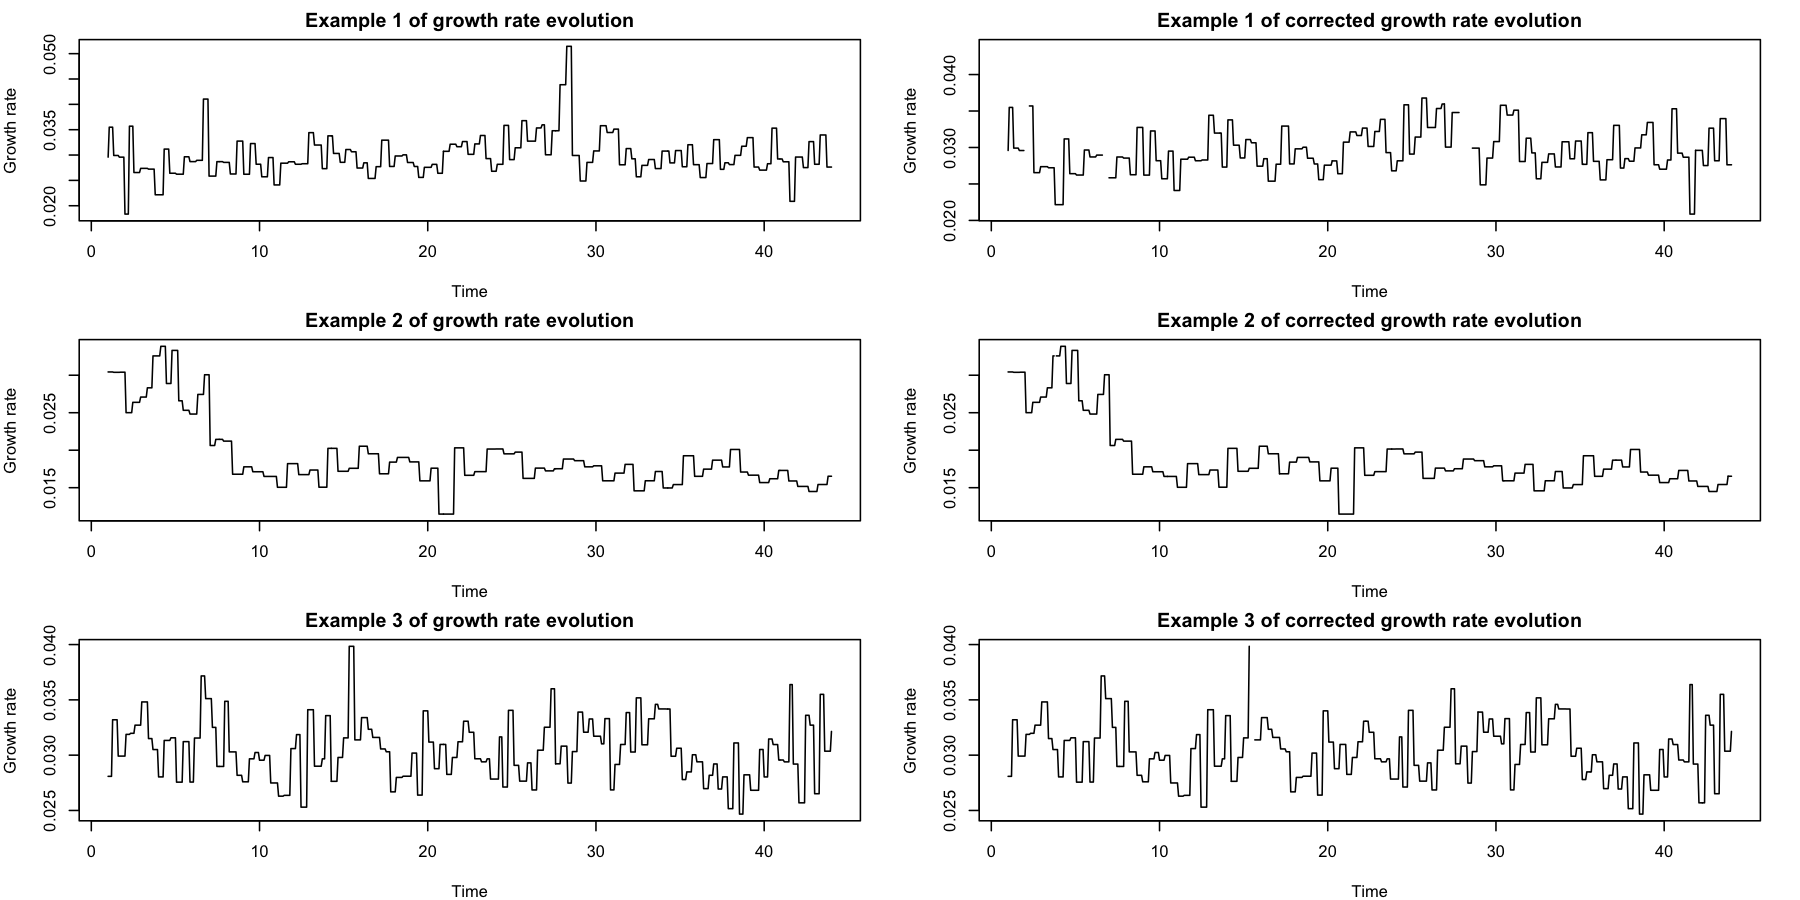

In [36]:
# Let us look at some examples:

par(mfrow=c(3,2), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:3){
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
    plot(tmin:tmax*4/60, microMA_MutH_growthRates_nodead_noab[, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of corrected growth rate evolution"))
}

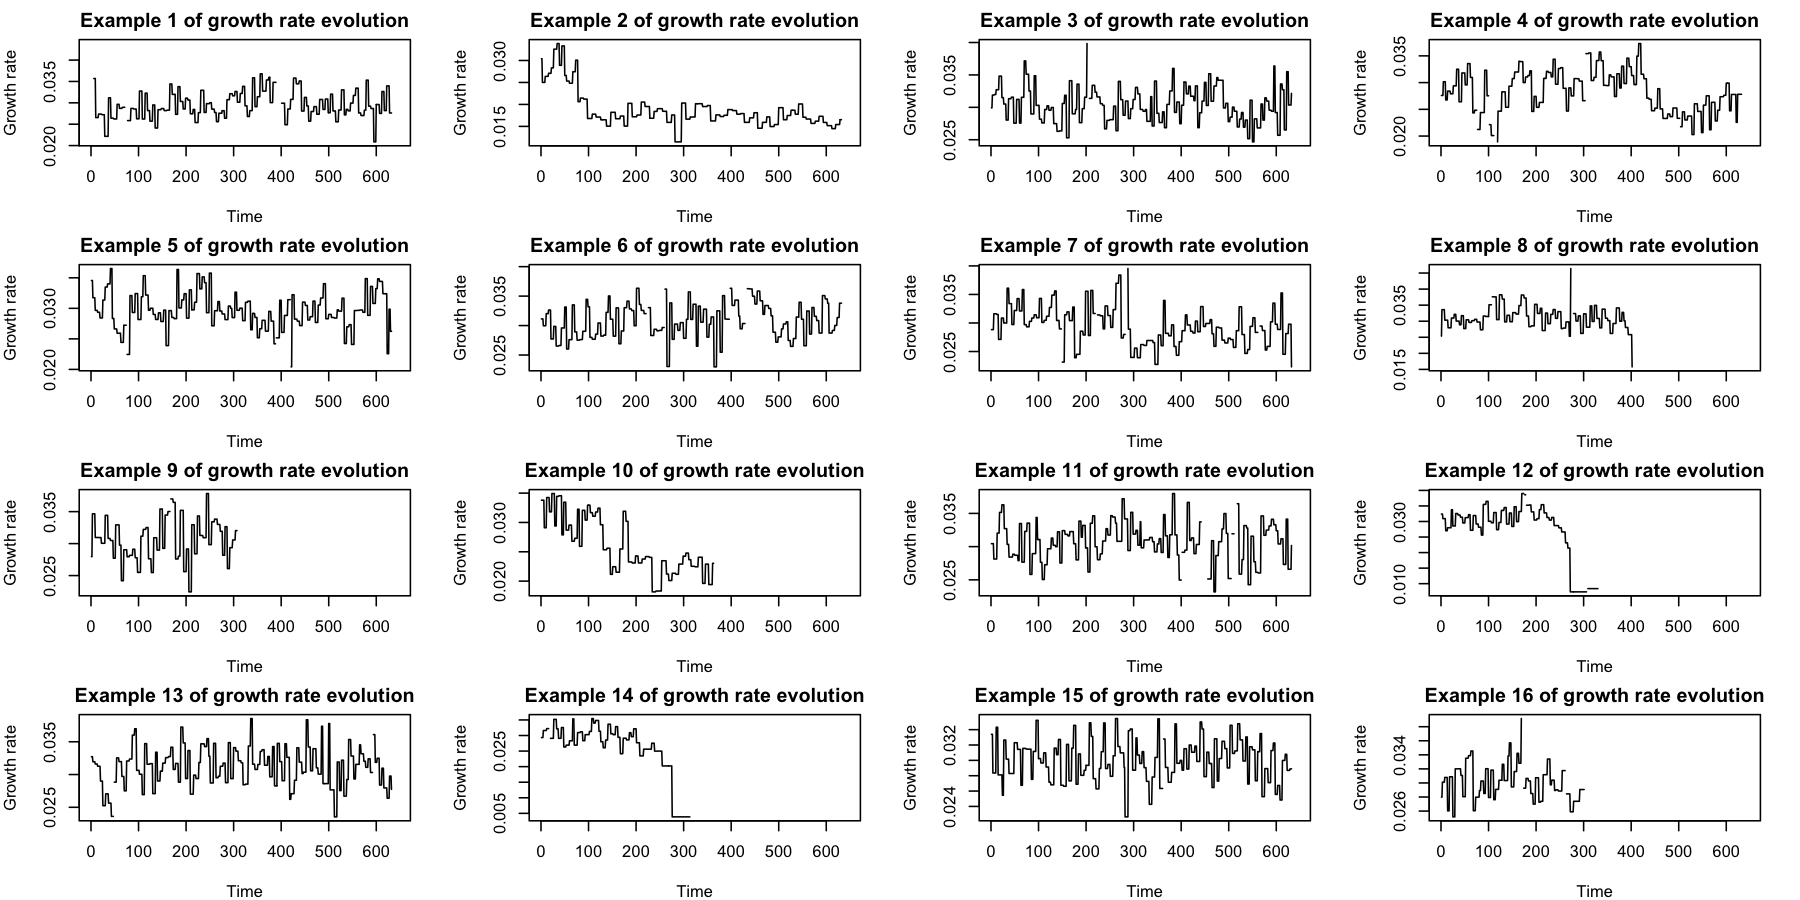

In [37]:
# Let us look at some examples:

par(mfrow=c(4,4), mar = c(4, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)

for (i in 1:16){
    plot(microMA_MutH_growthRates_nodead_noab[tmin:tmax, i], type="l", xlab = "Time", ylab = "Growth rate", main = paste("Example",i,"of growth rate evolution"))
}

In [38]:
write.csv2(microMA_WT_growthRates_NAdead_NAab, "Modified_data/data_microMA/dataset_microMA_WT_growthRates_NAdead_NAab.csv")
write.csv2(microMA_MutH_growthRates_nodead_noab, "Modified_data/data_microMA/dataset_microMA_MutH_growthRates_nodead_noab.csv")
write.csv2(microMA_MutT_growthRates_nodead_noab, "Modified_data/data_microMA/dataset_microMA_MutT_growthRates_nodead_noab.csv")
write.csv2(microMA_MF1_growthRates_nodead_noab, "Modified_data/data_microMA/dataset_microMA_MF1_growthRates_nodead_noab.csv")

### Estimation des moments

In [39]:
microMA_WT_growthRates_NAdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_WT_growthRates_NAdead_NAab.csv", row.names = 1)
microMA_MutH_growthRates_NAdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_MutH_growthRates_nodead_noab.csv", row.names = 1)
microMA_MutT_growthRates_NAdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_MutT_growthRates_nodead_noab.csv", row.names = 1)
microMA_MF1_growthRates_NAdead_NAab <- read.csv2("Modified_data/data_microMA/dataset_microMA_MF1_growthRates_nodead_noab.csv", row.names = 1)

In [40]:
moment_expectation <- function(k, dataset){
  return (rowMeans(dataset**k, na.rm = T))
}

log_choose <- function(k, n, moments_expectations){
  return ((-1)**k*choose(n,k)*log(moments_expectations[,k]))
}

k_values=1:10
moments_expectations_clean_MutH <- data.frame(sapply(k_values, 
                                                     moment_expectation, 
                                                     dataset=microMA_MutH_growthRates_nodead_noab))
names(moments_expectations_clean_MutH) <- paste("k.", k_values, sep = "")

moments_expectations_clean_WT <- data.frame(sapply(k_values, 
                                                   moment_expectation, 
                                                   dataset=microMA_WT_growthRates_NAdead_NAab))
names(moments_expectations_clean_WT) <- paste("k.", k_values, sep = "")

moments_expectations_clean_MutT <- data.frame(sapply(k_values, 
                                                     moment_expectation, 
                                                     dataset=microMA_MutT_growthRates_nodead_noab))
names(moments_expectations_clean_MutT) <- paste("k.", k_values, sep = "")

moments_expectations_clean_MF1 <- data.frame(sapply(k_values, 
                                                    moment_expectation, 
                                                    dataset=microMA_MF1_growthRates_nodead_noab))
names(moments_expectations_clean_MF1) <- paste("k.", k_values, sep = "")

Warning message in rlm.default(x, y, weights, method = method, wt.method = wt.method, :
“'rlm' failed to converge in 20 steps”


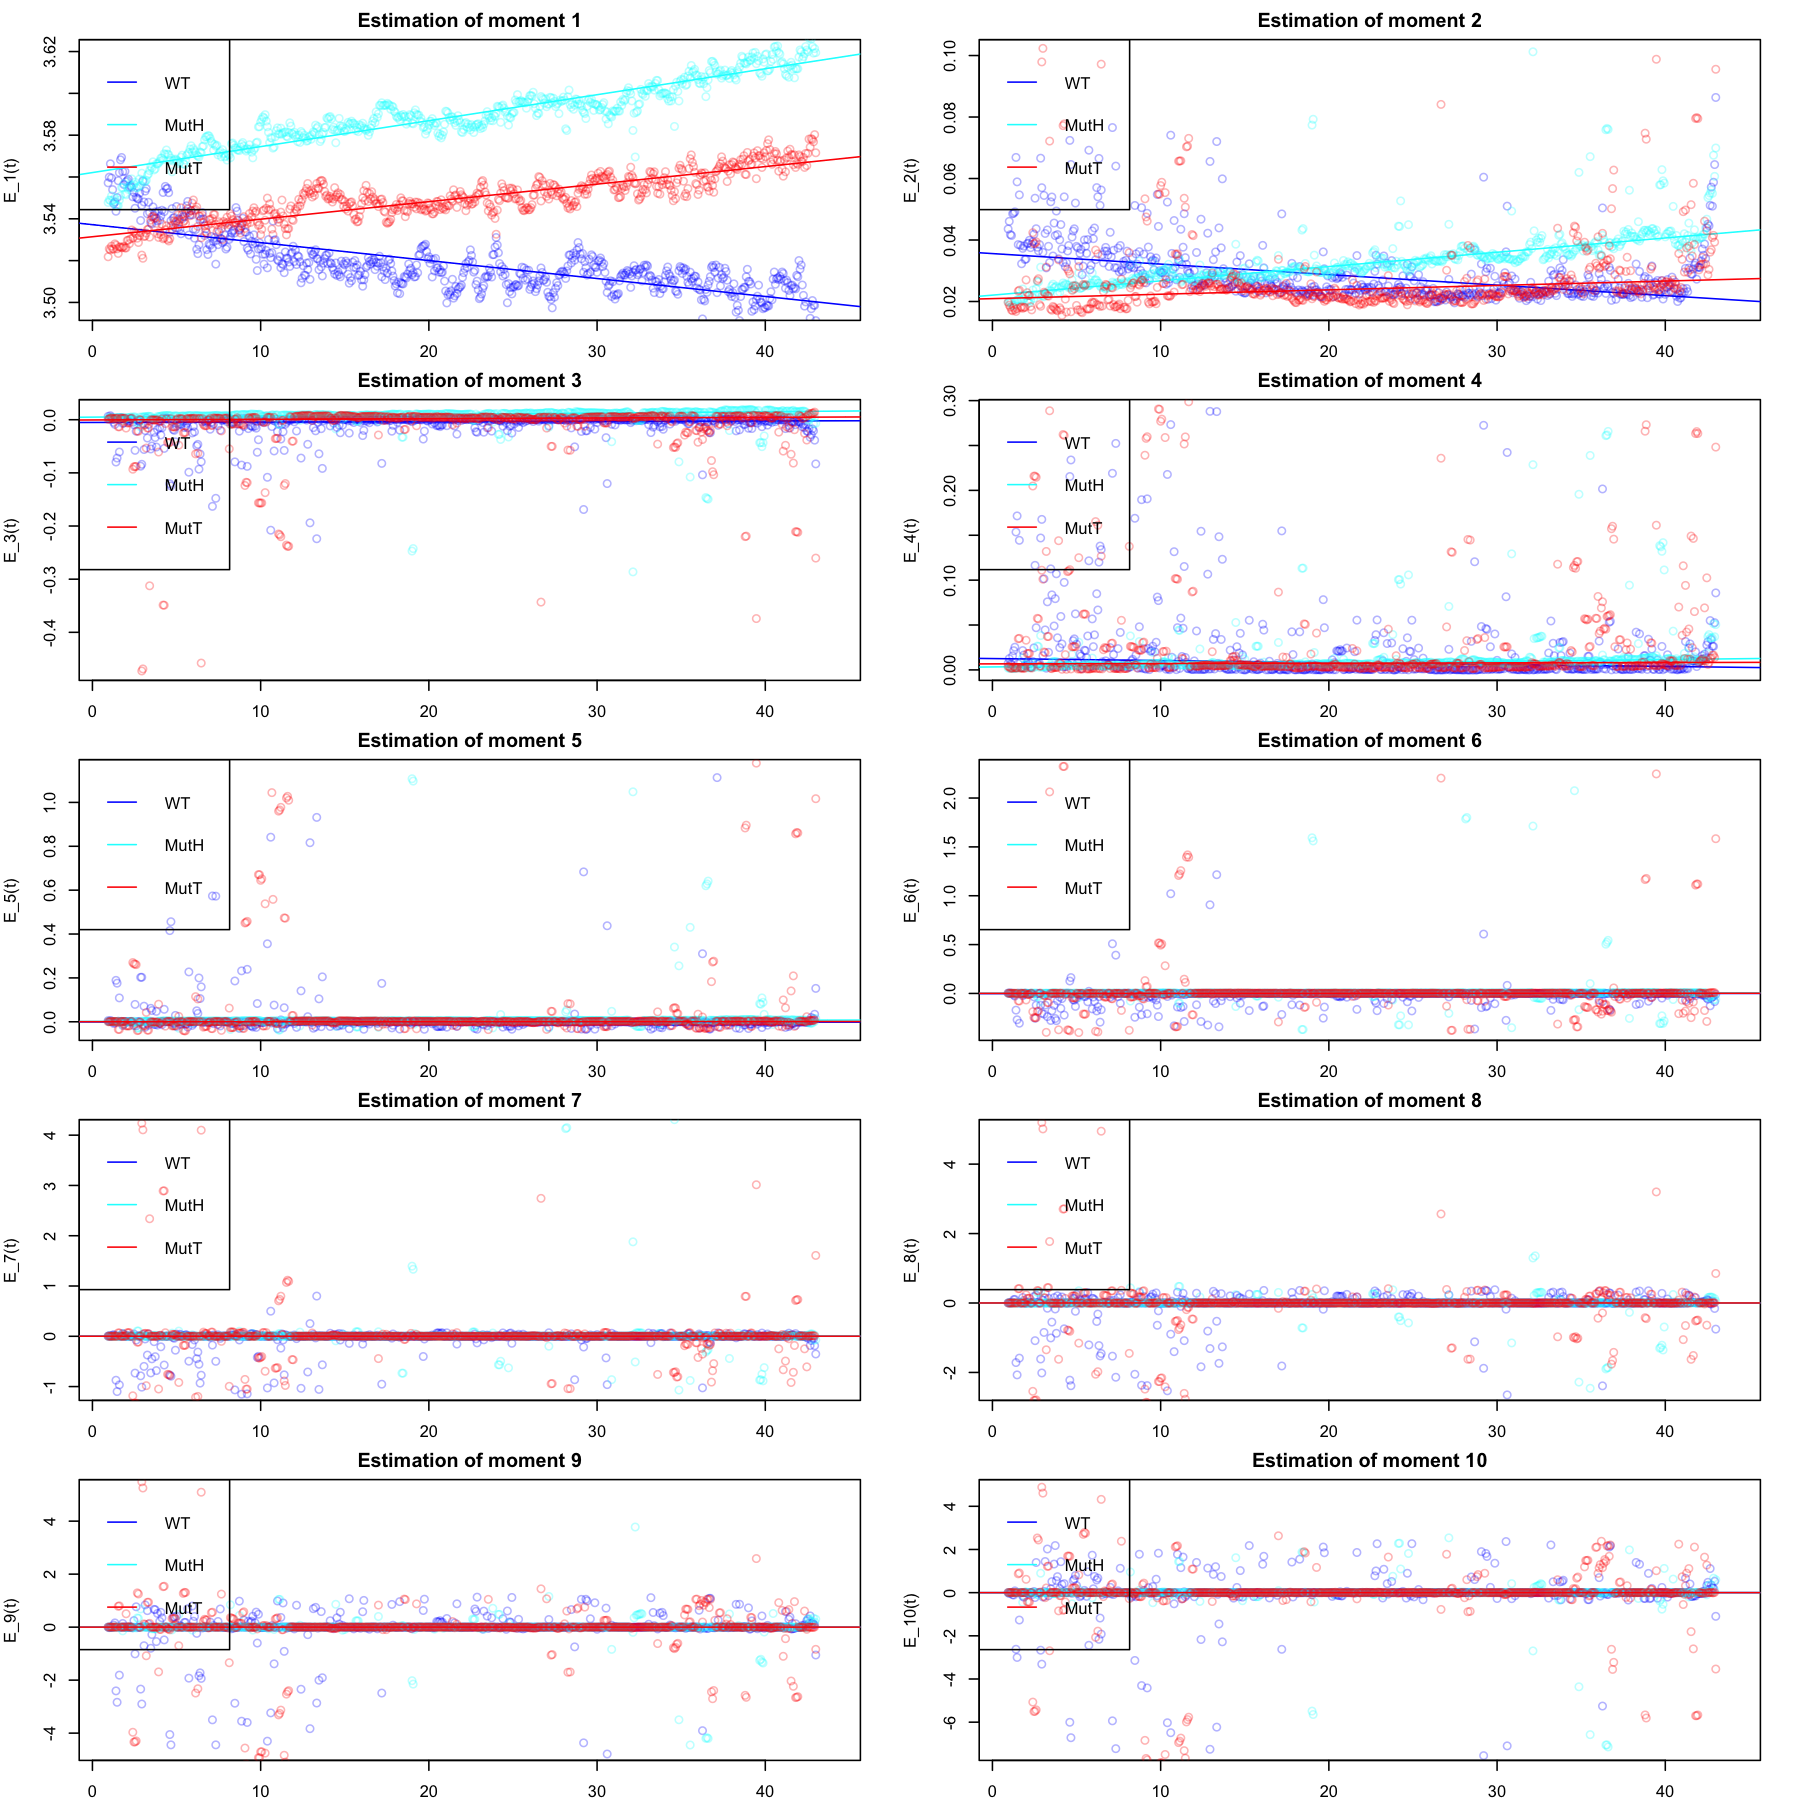

In [41]:
time_window=tmin:tmax
par(mfrow = c(5,2), mar = c(2, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

N <- 10
slopes <- data.frame(n = 1:N, 
                     slope_MutH = rep(NA,N),
                     slope_MutT = rep(NA,N), 
                     slope_MF1 = rep(NA,N),
                     slope_WT = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                       E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH[time_window,])),
                       E_nt_MutT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutT[time_window,])),
                       E_nt_WT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_WT[time_window,])))
    
    
    ### WT
    plot(x = df_n$time, 
         y = df_n$E_nt_WT, 
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = alpha("blue", 0.3),
         main = paste("Estimation of moment", n),
         ylim = quantile(df_n[,c("E_nt_WT", "E_nt_MutH", "E_nt_MutT")], c(0.005, 0.995), na.rm=T))
    
    lin_reg_WT <- rlm(E_nt_WT~time, data=df_n)
    abline(lin_reg_WT, col="blue", lwd=1)
    #slopes[n,7:11] <- c(summary(lin_reg_WT)$coefficients[2,c(1,2)]/60, summary(lin_reg_WT)$r.squared, mean(abs(resid(lin_reg_WT))), sqrt(mean(resid(lin_reg_WT)**2)))
    slopes$slope_WT[n] <- c(summary(lin_reg_WT)$coefficients[2,c(1)]/60)
    
    
    
    ### MutH
    points(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           col = alpha("cyan", 0.3))
    
    lin_reg_MutH <- rlm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="cyan", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutH[n] <- c(summary(lin_reg_MutH)$coefficients[2,c(1)]/60)
    
        
    ### MutT
    points(x = df_n$time, 
           y = df_n$E_nt_MutT,
           col = alpha("red", 0.3))
    
    lin_reg_MutT <- rlm(E_nt_MutT~time, data=df_n)
    abline(lin_reg_MutT, col="red", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutT[n] <- c(summary(lin_reg_MutT)$coefficients[2,c(1)]/60)
    
    
    legend("topleft", legend = c("WT", "MutH", "MutT"), col=c("blue", "cyan", "red"), lty=1, seg.len = 1, text.width=3)
    
}

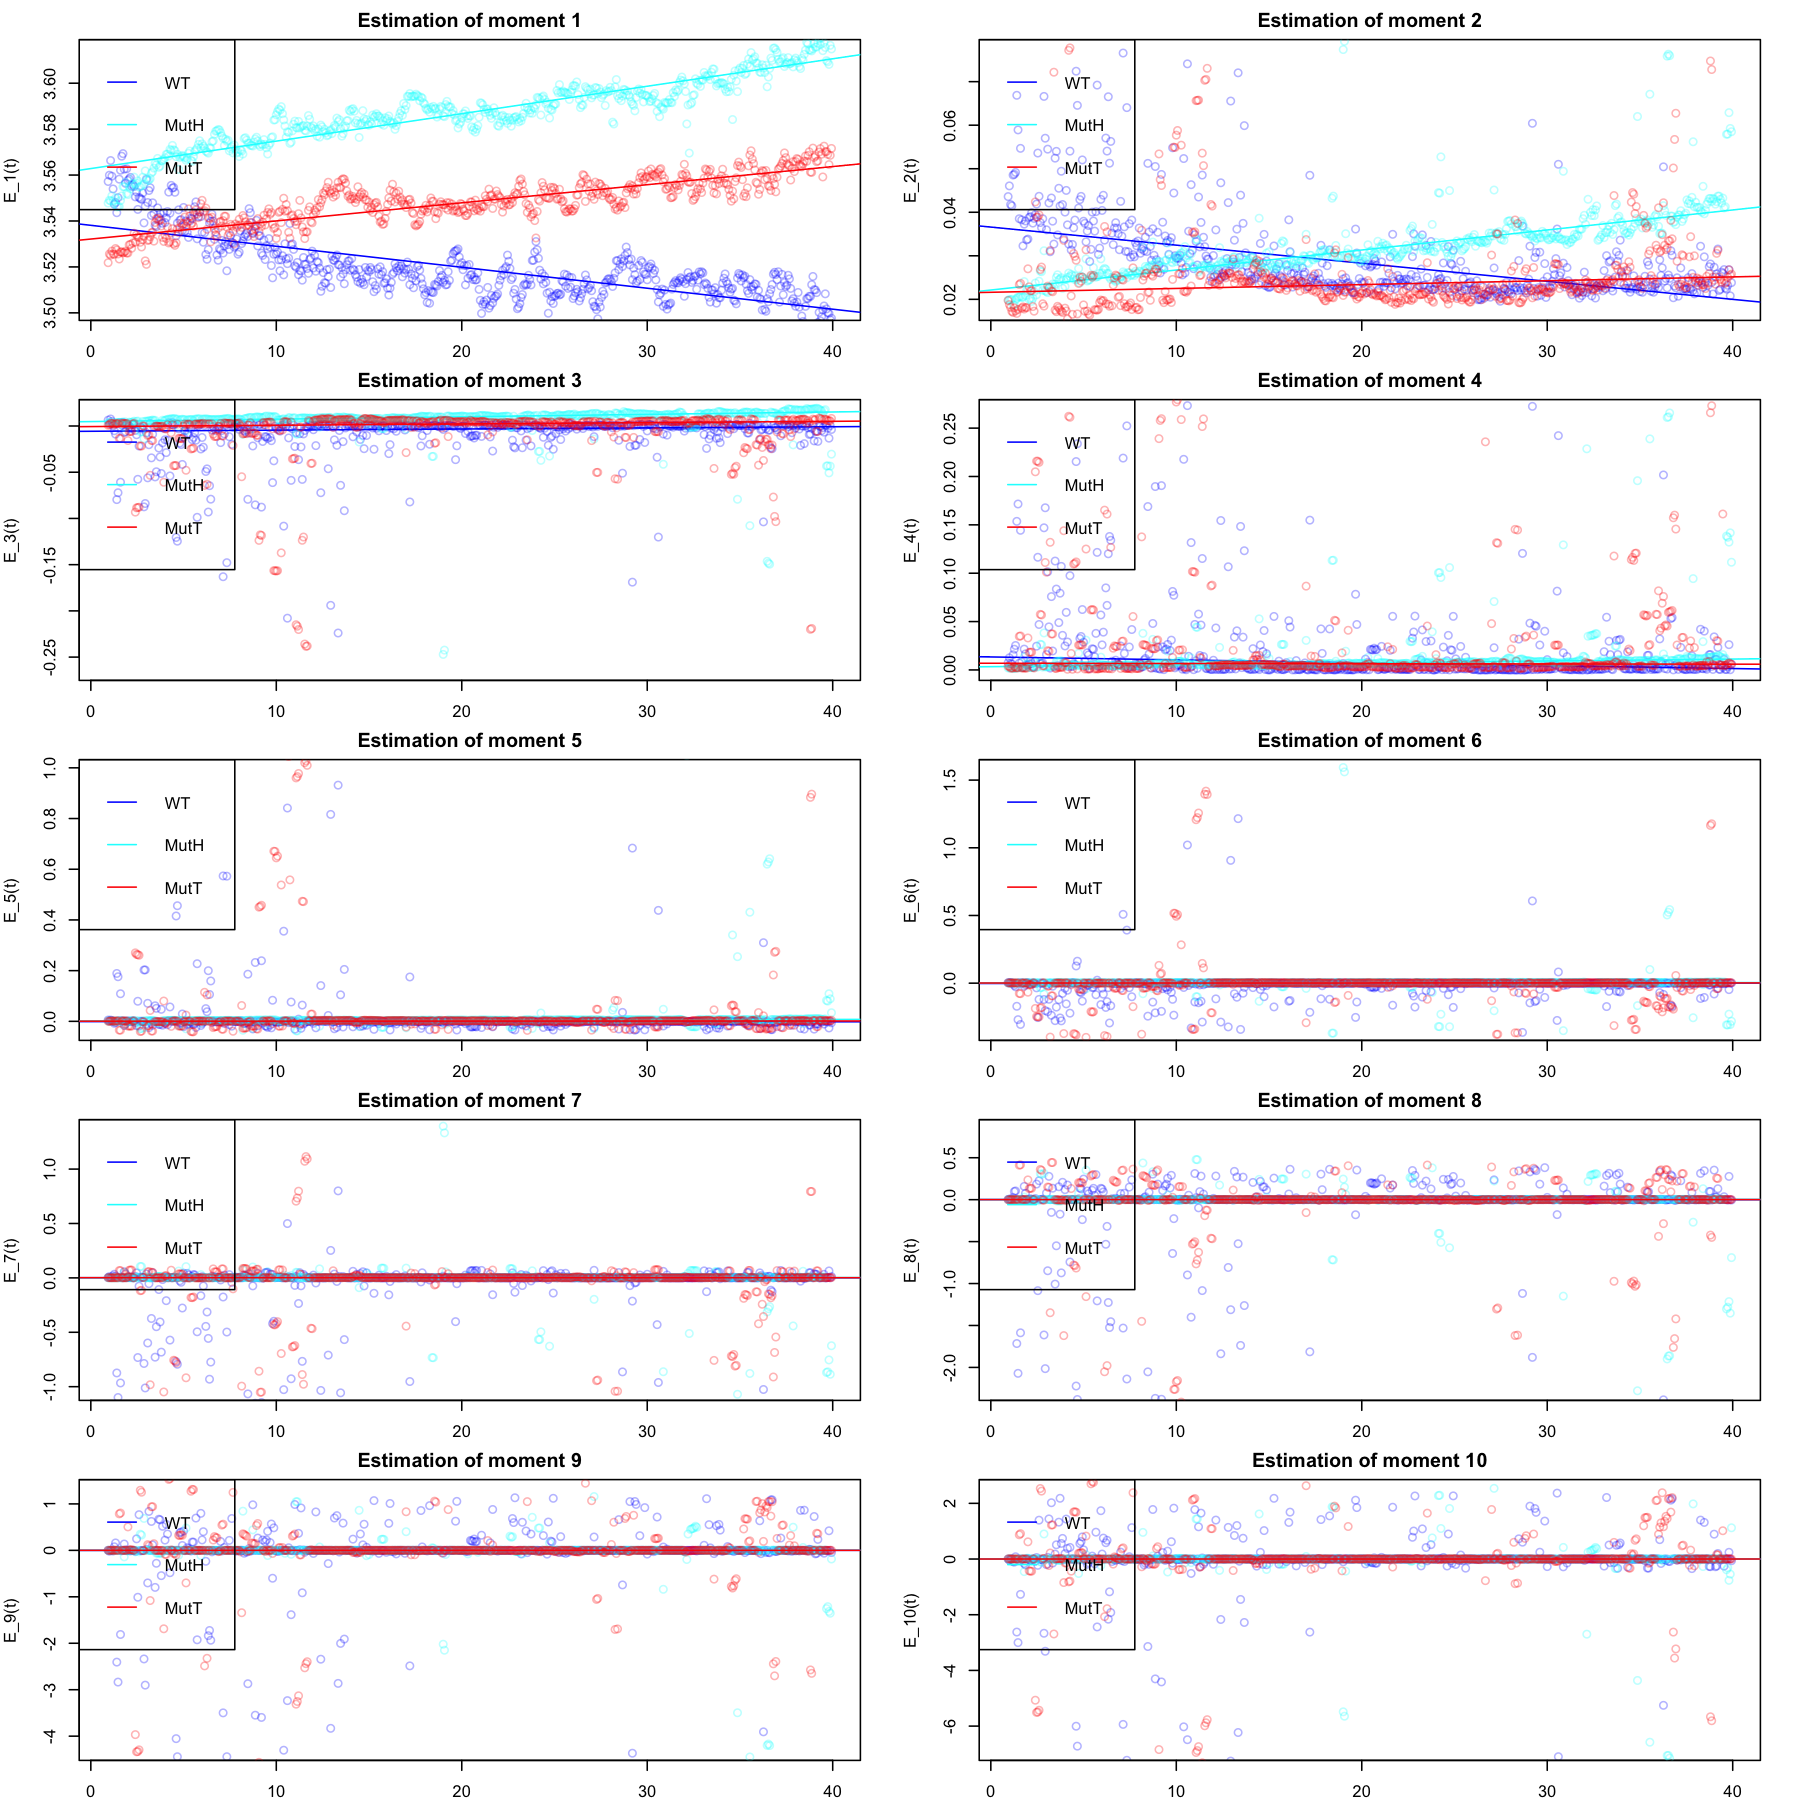

In [42]:
time_window=tmin:(tmax-4*15)
par(mfrow = c(5,2), mar = c(2, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

N <- 10
#slopes <- data.frame(n = 1:N,
#                     slope_MutH = rep(NA,N), std_err_MutH = rep(NA,N), r2_MutH = rep(NA,N), resid_L1_MutH = rep(NA,N), resid_L2_MutH = rep(NA,N), 
#                     slope_WT = rep(NA,N), std_err_WT = rep(NA,N), r2_WT = rep(NA,N), resid_L1_WT = rep(NA,N), resid_L2_WT = rep(NA,N))
slopes <- data.frame(n = 1:N, 
                    slope_MutH = rep(NA,N),
                    slope_MutT = rep(NA,N), 
                    slope_MF1 = rep(NA,N),
                    slope_WT = rep(NA,N))

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_MutH = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutH[time_window,])),
                     E_nt_MutT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MutT[time_window,])),
                     E_nt_WT = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_WT[time_window,])))
    
    
    ### WT
    plot(x = df_n$time, 
         y = df_n$E_nt_WT, 
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = alpha("blue", 0.3),
         main = paste("Estimation of moment", n),
         ylim = quantile(df_n[,c("E_nt_WT", "E_nt_MutH", "E_nt_MutT")], c(0.01, 0.99), na.rm=T))
    
    lin_reg_WT <- rlm(E_nt_WT~time, data=df_n)
    abline(lin_reg_WT, col="blue", lwd=1)
    #slopes[n,7:11] <- c(summary(lin_reg_WT)$coefficients[2,c(1,2)]/60, summary(lin_reg_WT)$r.squared, mean(abs(resid(lin_reg_WT))), sqrt(mean(resid(lin_reg_WT)**2)))
    slopes$slope_WT[n] <- c(summary(lin_reg_WT)$coefficients[2,c(1)]/60)
    
    
    
    ### MutH
    points(x = df_n$time, 
           y = df_n$E_nt_MutH, 
           col = alpha("cyan", 0.3))
    
    lin_reg_MutH <- rlm(E_nt_MutH~time, data=df_n)
    abline(lin_reg_MutH, col="cyan", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutH[n] <- c(summary(lin_reg_MutH)$coefficients[2,c(1)]/60)
    
        
    ### MutT
    points(x = df_n$time, 
           y = df_n$E_nt_MutT,
           col = alpha("red", 0.3))
    
    lin_reg_MutT <- rlm(E_nt_MutT~time, data=df_n)
    abline(lin_reg_MutT, col="red", lwd=1)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MutT[n] <- c(summary(lin_reg_MutT)$coefficients[2,c(1)]/60)
    
    
    legend("topleft", legend = c("WT", "MutH", "MutT"), col=c("blue", "cyan", "red"), lty=1, seg.len = 1, text.width=3)
    
}

![](Img/Moments_estimation.png)

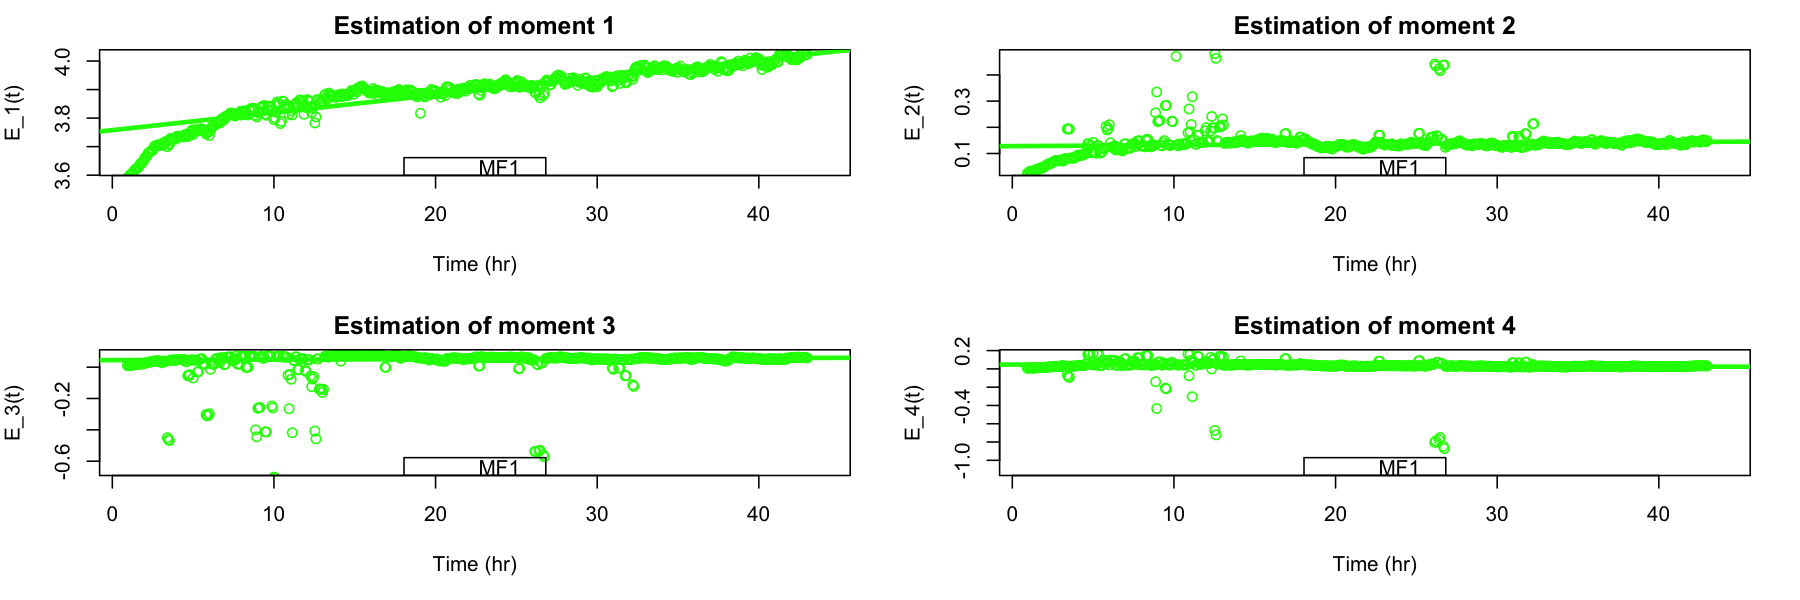

In [43]:
time_window=tmin:(tmax)
par(mfrow = c(2,2), mar = c(5, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 150)

for (n in 1:4){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_MF1 = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MF1[time_window,])))

    
    ### MF1
    plot(x = df_n$time, 
         y = df_n$E_nt_MF1,
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""), 
         ylim = quantile(df_n$E_nt_MF1, c(0.01, 0.99), na.rm=T),
         col = "green",
         main = paste("Estimation of moment", n))
    
    lin_reg_MF1 <- rlm(E_nt_MF1~time, data=df_n)
    abline(lin_reg_MF1, col="green", lwd=3)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MF1[n] <- c(summary(lin_reg_MF1)$coefficients[2,c(1)]/60)

    
  legend("bottom", legend = c("MF1"), col=c("green"), seg.len = 1, text.width=3)
    
}

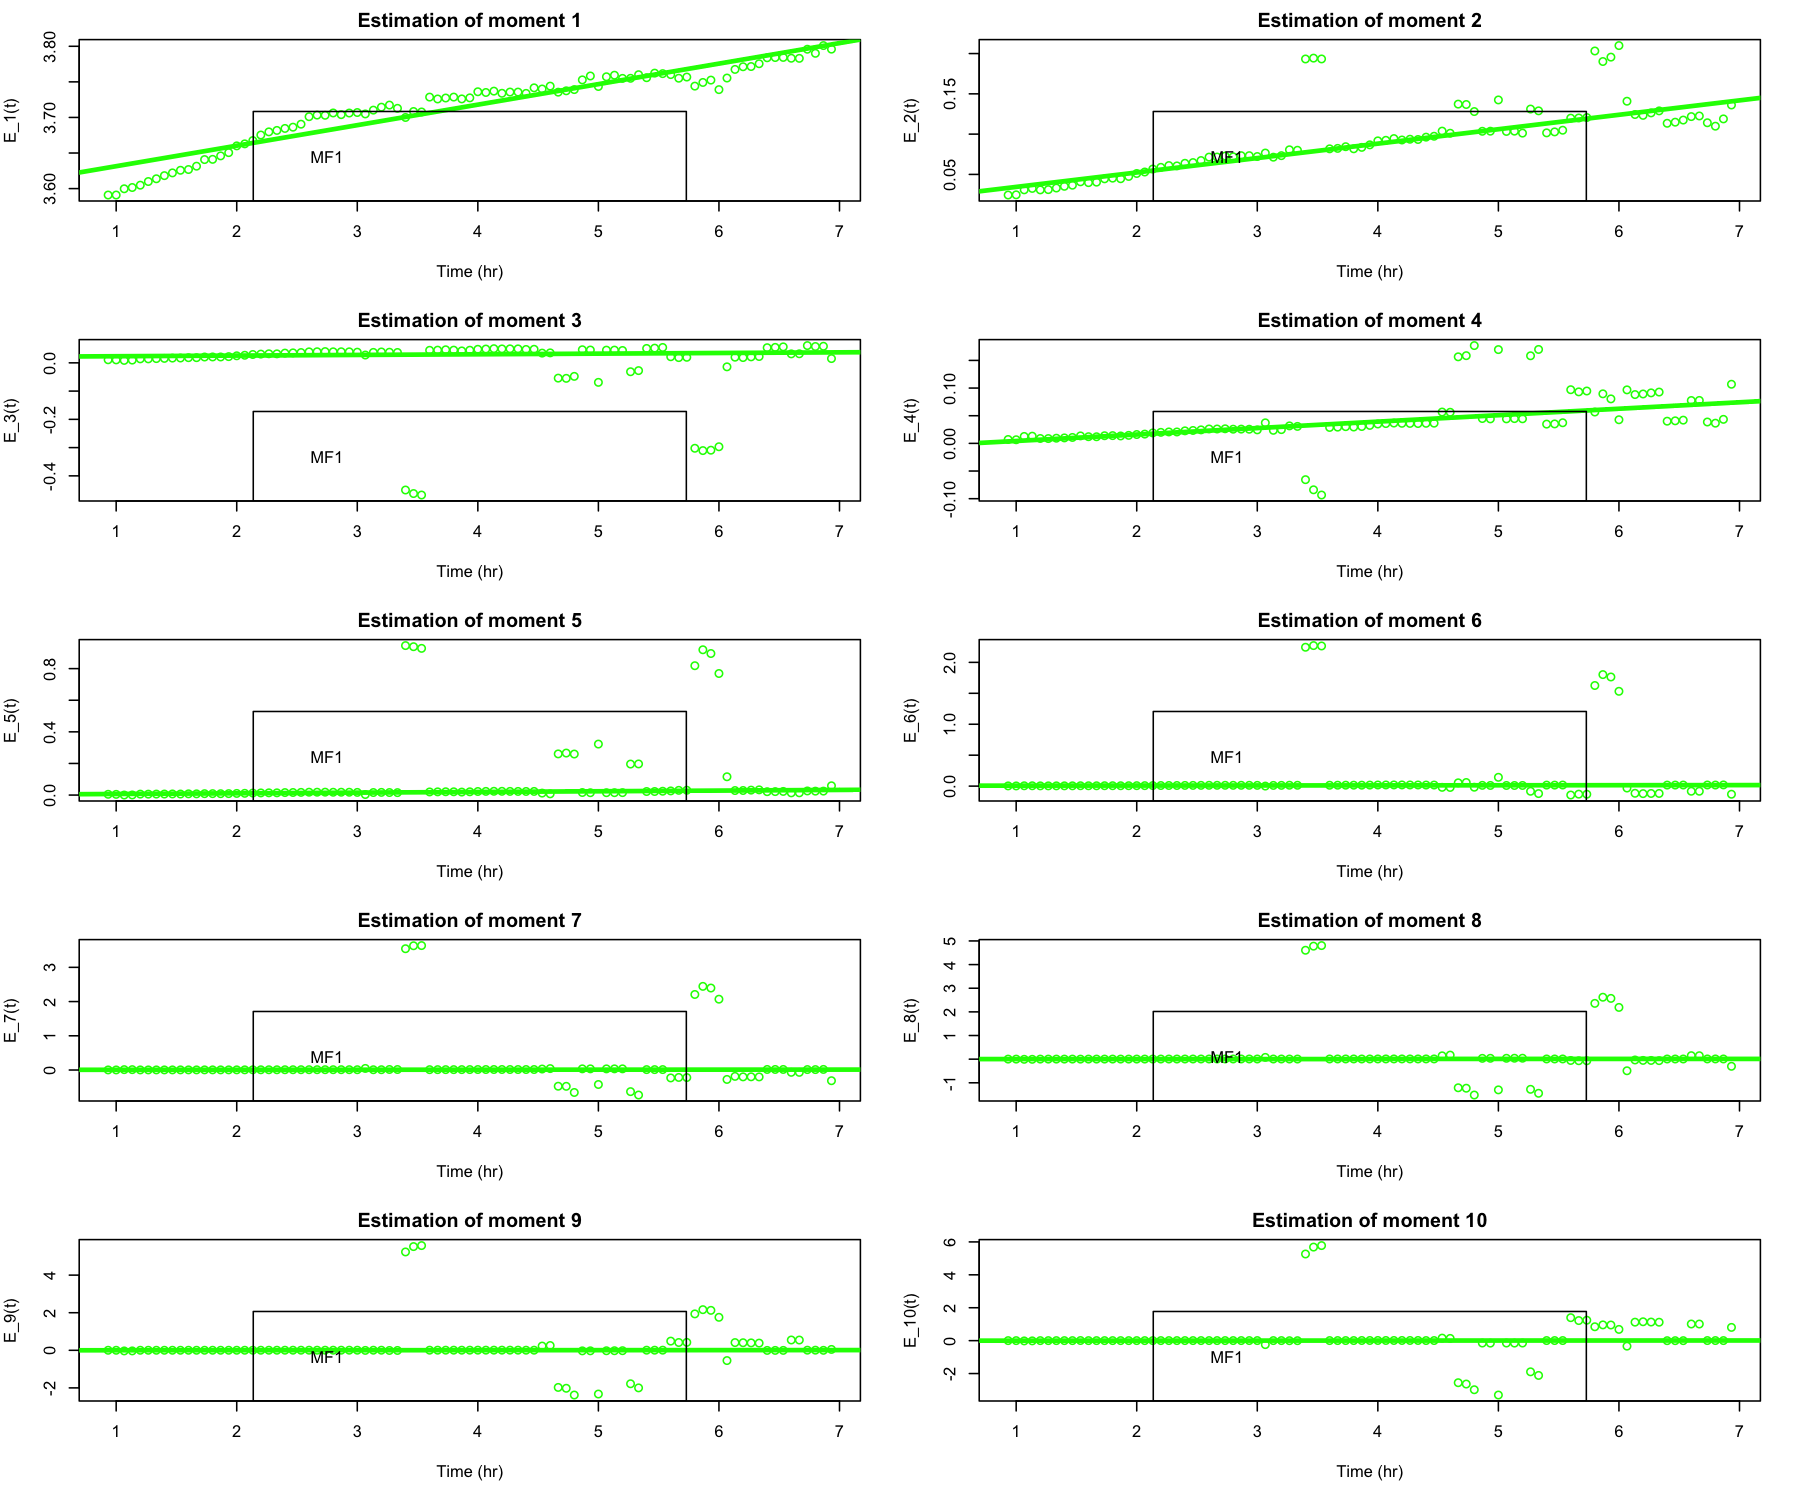

In [44]:
time_window=tmin:(tmax-37*15)
par(mfrow = c(5,2), mar = c(5, 4, 2, 2))
options(repr.plot.width = 12, repr.plot.height = 10, repr.plot.res = 150)

for (n in 1:N){
    df_n <- data.frame(time = microMA_MutH[time_window,]$time/60,
                     E_nt_MF1 = rowSums(sapply(1:n, log_choose, n=n, moments_expectations=moments_expectations_clean_MF1[time_window,])))

    
    ### MF1
    plot(x = df_n$time, 
         y = df_n$E_nt_MF1,
         xlab = "Time (hr)",
         ylab = paste("E_", n, "(t)", sep = ""),
         col = "green",
         main = paste("Estimation of moment", n))
    
    lin_reg_MF1 <- rlm(E_nt_MF1~time, data=df_n)
    abline(lin_reg_MF1, col="green", lwd=3)
    #slopes[n,2:6] <- c(summary(lin_reg_MutH)$coefficients[2,c(1,2)]/60, summary(lin_reg_MutH)$r.squared, mean(abs(resid(lin_reg_MutH))), sqrt(mean(resid(lin_reg_MutH)**2)))
    slopes$slope_MF1[n] <- c(summary(lin_reg_MF1)$coefficients[2,c(1)]/60)

    
  legend("bottom", legend = c("MF1"), col=c("green"), seg.len = 1, text.width=3)
    
}

In [45]:
mult_factor = c(10**5, 10**6, 10**6, rep(10**7, 7))
cbind(slopes[1], mult_factor=mult_factor, signif(slopes[-1], digits=2)*mult_factor)

n  mult_factor slope_MutH slope_MutT slope_MF1 slope_WT
1   1 1e+05        2.0        1.30        48       -1.5   
2   2 1e+06        7.7        1.50       300       -6.9   
3   3 1e+06        4.4        2.40        38        2.0   
4   4 1e+07       33.0       -4.50      1900      -51.0   
5   5 1e+07       24.0        4.50       740       -4.6   
6   6 1e+07       17.0        3.00       250       11.0   
7   7 1e+07       12.0       -0.45       200       -2.3   
8   8 1e+07        9.3        0.92       190       -4.9   
9   9 1e+07        7.4        1.00       260        4.7   
10 10 1e+07        6.7        1.70       410        7.6

 ![](Img/Slope_values.png)